In [1]:
from __future__ import print_function, division
from torcheval.metrics.functional import multiclass_f1_score
from sklearn.metrics import f1_score

import os
import time
import copy
import torch
import torch.onnx
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torchvision import datasets, models
import torchvision.transforms as transforms

%matplotlib inline

plt.ion()

In [2]:
#get address such as C:\\(folder with you notebook)
dir = os.path.abspath(os.curdir)
# i suppose what your image folders placed in datasets directory 
data_dir=os.path.join(dir, "datasets\\")

# Data scaled and normalization for training and testing
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(32),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.RandomResizedCrop(32),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

#Create function to get your(my) images dataset and resize it to size for model
def get_dataset(data_dir, data_transforms):


    # create train and test datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
                      for x in ['train', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    #get classes from train dataset folders name
    classes = image_datasets['train'].classes

    return dataloaders["train"], dataloaders['test'], classes, dataset_sizes

In [3]:
# get train and test data
trainloader, testloader, classes, dataset_sizes=get_dataset(data_dir,data_transforms)
print('Classes: ',  classes)
print('The datasets have: ',  dataset_sizes ," images")

Classes:  ['Археология', 'Графика', 'ДПИ', 'Документы', 'Естественнонауч.коллекция', 'Живопись', 'Минералогия', 'Нумизматика', 'Оружие', 'Печатная продукция', 'Прочие', 'Редкие книги', 'Скульптура', 'Техника', 'Фото, негативы']
The datasets have:  {'train': 19982, 'test': 360}  images


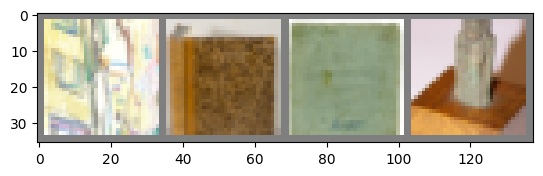

Графика Редкие книги Графика Скульптура


In [4]:
def imshow(img):
    img = img / 2+0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 15)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=15, bias=True)
)


In [9]:
criterion = nn.SoftMarginLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cpu")

In [10]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #print(inputs)
        #print(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        #loss = multiclass_f1_score(inputs, outputs, num_classes=15)
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 15 == 14:    # print every 15 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 15))
            running_loss = 0.0

print('Finished Training')

RuntimeError: The size of tensor a (15) must match the size of tensor b (4) at non-singleton dimension 1

Predict class - Скульптура, real class - Нумизматика, probability (Археология,Графика) - tensor([-0.4215, -0.4452,  1.0713, -2.5428,  0.7848,  0.9128,  0.8130,  0.8846,
        -1.1817, -0.7952,  0.4341,  0.5026,  1.0881,  0.5416, -1.3351])
Predict class - Печатная продукция, real class - Графика, probability (Археология,Графика) - tensor([-0.6422,  0.6699, -0.3422,  1.6136,  0.4673, -1.1904, -1.3284, -0.7753,
        -0.7347,  1.6649,  0.4815,  1.2077, -0.4379, -0.1852,  0.1082])
Predict class - Техника, real class - Прочие, probability (Археология,Графика) - tensor([-0.4207, -1.2670,  1.3068, -2.3939,  0.5848,  0.5052,  0.7932, -0.8165,
        -0.3747,  0.4012,  1.2788,  0.6593, -0.0940,  1.4251, -0.0236])
Predict class - Нумизматика, real class - Нумизматика, probability (Археология,Графика) - tensor([ 2.5013, -1.3524,  2.7924, -4.2347,  3.3797, -2.8836,  2.9781,  4.2886,
        -1.6870, -3.1088,  1.9584,  2.0617,  2.2482,  1.5939, -6.4413])


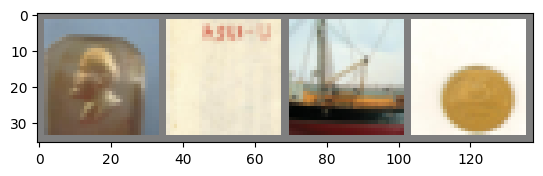

GroundTruth:  Скульптура Печатная продукция Техника Нумизматика
Predict class - Археология, real class - Печатная продукция, probability (Археология,Графика) - tensor([ 1.7036, -0.7196, -0.3741, -1.3301,  0.5203, -1.0384, -1.3309,  0.5567,
        -0.1566,  0.7628,  1.4603, -0.1183,  0.4997,  0.3299,  0.4316])
Predict class - Живопись, real class - Живопись, probability (Археология,Графика) - tensor([-2.0573,  0.1762,  1.5338, -3.8034, -0.2090,  2.7610, -1.5418,  0.0385,
        -1.2670, -0.8639,  0.6070,  1.1961,  2.0146,  1.1104, -1.2564])
Predict class - Редкие книги, real class - Графика, probability (Археология,Графика) - tensor([-0.7651,  0.9693,  0.4577, -0.3865,  0.6265, -0.0848, -0.2759,  0.4480,
        -2.1439,  0.6895,  0.0537,  1.1083,  0.1270, -0.3296, -0.2627])
Predict class - Техника, real class - Редкие книги, probability (Археология,Графика) - tensor([-2.6562, -2.3509,  2.0620, -3.3893, -2.0718,  0.9926,  0.2646,  0.7168,
        -1.7775,  0.1582,  2.0775,  1.6947,  1

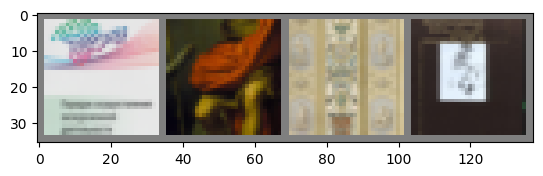

GroundTruth:  Археология Живопись Редкие книги Техника
Predict class - Естественнонауч.коллекция, real class - Естественнонауч.коллекция, probability (Археология,Графика) - tensor([ 0.8552, -1.2783,  1.4361, -3.2224,  2.3510, -1.6999,  0.9667,  0.5987,
         0.3808, -1.8770,  1.4004, -1.7144,  1.8608,  1.7784, -1.4380])
Predict class - Фото, негативы, real class - ДПИ, probability (Археология,Графика) - tensor([-1.4396, -0.5304,  0.4361, -0.5557, -0.0457,  0.6998, -0.3538, -1.0390,
        -0.5385,  0.6324,  0.5106,  0.3288, -0.0974,  0.4159,  1.4980])
Predict class - Фото, негативы, real class - Графика, probability (Археология,Графика) - tensor([-2.0841,  0.2188,  0.1298, -1.6955,  0.1815,  0.9618,  0.0451, -0.3851,
        -1.4270,  0.0164,  0.0385, -0.1167,  1.0833,  0.6594,  1.2642])
Predict class - Фото, негативы, real class - ДПИ, probability (Археология,Графика) - tensor([-1.4921, -0.0583,  1.0535, -1.1957,  0.2218,  0.1387,  0.2212, -0.7631,
        -1.1382,  1.0017,  0.713

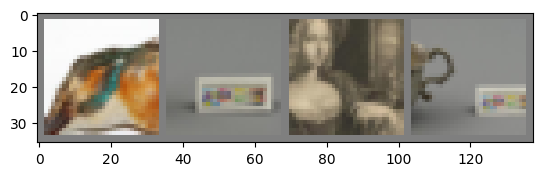

GroundTruth:  Естественнонауч.коллекция Фото, негативы Фото, негативы Фото, негативы
Predict class - Фото, негативы, real class - Фото, негативы, probability (Археология,Графика) - tensor([-1.8912, -0.4133,  0.1220, -2.7673, -0.3534, -0.3704,  0.6226, -0.3782,
        -1.5971,  0.6220,  1.0718,  0.3995,  1.4100,  1.4058,  2.7047])
Predict class - Прочие, real class - Прочие, probability (Археология,Графика) - tensor([ 0.5388, -1.1548,  1.5884, -1.7300,  2.1886, -0.4631, -0.2486, -1.1465,
         0.4980,  0.3641,  2.3079, -1.0635, -0.0359,  1.9369, -1.0793])
Predict class - Редкие книги, real class - Документы, probability (Археология,Графика) - tensor([-0.9968, -0.1510,  0.5287,  0.2828, -0.7292,  0.5246, -1.1456,  0.6938,
        -1.8076,  1.0849,  0.3270,  2.5295, -0.3184, -0.2997, -0.6469])
Predict class - Документы, real class - ДПИ, probability (Археология,Графика) - tensor([-1.3313,  0.0801,  0.8999,  1.7803,  0.4129,  0.0641, -1.5587, -1.0053,
        -1.0991,  1.2842,  0.9059,

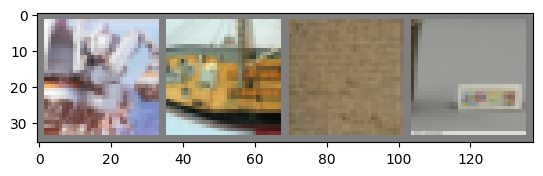

GroundTruth:  Фото, негативы Прочие Редкие книги Документы
Predict class - Минералогия, real class - Фото, негативы, probability (Археология,Графика) - tensor([-1.6956, -0.8054,  0.4028, -1.2051, -1.0108,  0.9327,  1.3802,  0.3178,
        -1.6145,  0.3637,  0.3855,  0.4245,  0.8632,  0.9600,  1.0006])
Predict class - Фото, негативы, real class - Фото, негативы, probability (Археология,Графика) - tensor([-2.7910, -0.8781,  0.0625, -2.8700, -0.3090, -0.5049,  0.4235, -0.9914,
        -1.4426, -0.0865,  1.3076, -0.4091,  2.2632,  1.8014,  3.8810])
Predict class - Живопись, real class - Техника, probability (Археология,Графика) - tensor([-1.1509, -0.4459,  1.4830, -2.2774,  0.8406,  1.5961, -0.2247, -0.5140,
        -0.7911, -0.0637,  0.8027,  0.0510,  0.2374,  0.8721, -0.7784])
Predict class - Редкие книги, real class - Печатная продукция, probability (Археология,Графика) - tensor([-2.1883,  0.1627,  0.7884,  2.7900, -1.1699, -0.2494, -2.1410, -1.1561,
        -2.0390,  2.2542,  1.0575, 

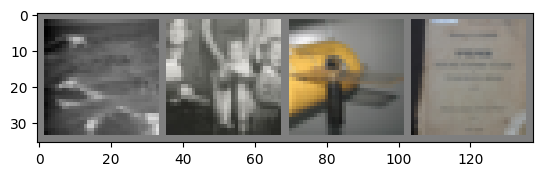

GroundTruth:  Минералогия Фото, негативы Живопись Редкие книги
Predict class - Редкие книги, real class - Документы, probability (Археология,Графика) - tensor([-1.8939,  4.1329, -0.3994,  3.5516, -0.2684, -2.1084, -3.9461, -2.3536,
        -2.4893,  1.3953, -0.0473,  4.3358, -0.4827, -0.9851,  1.1851])
Predict class - Оружие, real class - Прочие, probability (Археология,Графика) - tensor([ 0.3961, -3.1855,  1.7038, -2.7926,  1.5538, -0.3955,  0.9998, -2.3918,
         2.5841, -1.8484,  2.4772, -0.1138, -0.7816,  2.5840,  1.3014])
Predict class - Живопись, real class - Документы, probability (Археология,Графика) - tensor([-1.8904, -0.1587,  0.1383, -0.7304, -0.9468,  1.3853, -0.0657,  0.3097,
        -1.1254,  0.4409, -0.0890,  0.3340,  0.3173,  0.6013,  0.9845])
Predict class - Живопись, real class - Живопись, probability (Археология,Графика) - tensor([-2.6218, -0.1590,  0.8246, -2.5305, -0.5360,  2.1822, -0.0631, -0.1697,
        -1.2408, -0.2689,  0.2273,  0.2146,  1.2262,  1.1211,  

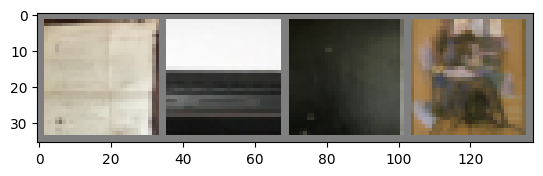

GroundTruth:  Редкие книги Оружие Живопись Живопись
Predict class - Археология, real class - Естественнонауч.коллекция, probability (Археология,Графика) - tensor([ 4.2760, -1.2867,  0.6322, -4.4047,  4.2364, -4.6335, -0.6775,  1.2473,
         1.9987, -2.5360,  2.0516, -4.5844,  1.9545,  2.1065, -0.5372])
Predict class - Археология, real class - Печатная продукция, probability (Археология,Графика) - tensor([ 2.6224, -1.8241,  0.0380, -2.1480,  0.6890, -2.2622, -0.8753,  0.6874,
         1.2316, -0.2015,  1.4045, -0.8574,  0.4753,  0.8376,  0.7470])
Predict class - Скульптура, real class - Скульптура, probability (Археология,Графика) - tensor([ 0.1498, -0.3814,  1.5694, -2.9577,  0.4857, -0.0440,  1.0875,  1.2757,
        -0.3870, -1.1062,  0.6519, -0.1669,  1.9026,  0.8727, -2.0057])
Predict class - ДПИ, real class - Скульптура, probability (Археология,Графика) - tensor([-0.4118, -1.3300,  1.4722, -2.7756,  0.9218,  0.7117,  0.9256,  0.1271,
        -0.1050, -1.7358,  1.2022, -0.2103, 

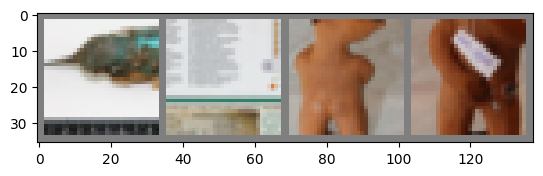

GroundTruth:  Археология Археология Скульптура   ДПИ
Predict class - Минералогия, real class - Минералогия, probability (Археология,Графика) - tensor([-0.5171, -1.0339,  1.1422, -1.8697,  0.4287,  0.2984,  2.4333, -0.2380,
        -0.2338, -0.6494,  0.8560,  0.1889, -0.0035,  1.3343, -0.4821])
Predict class - Редкие книги, real class - Графика, probability (Археология,Графика) - tensor([-0.9433,  1.4019,  0.0754,  0.7956, -0.0359, -0.3809, -1.2707,  0.1751,
        -1.7097,  1.3254, -0.2822,  1.5463, -0.4866, -0.4661, -0.0490])
Predict class - Естественнонауч.коллекция, real class - Естественнонауч.коллекция, probability (Археология,Графика) - tensor([ 0.5956, -0.1931,  0.1860, -0.3282,  1.4487, -1.0680, -0.5923,  0.4611,
        -0.3518,  0.5135,  0.6293, -0.1233,  0.2052,  0.2411, -0.4323])
Predict class - Фото, негативы, real class - Фото, негативы, probability (Археология,Графика) - tensor([-3.5169, -0.2146,  0.0461, -2.6499, -0.6233,  1.3489, -0.1019, -0.3338,
        -1.5856, -0.

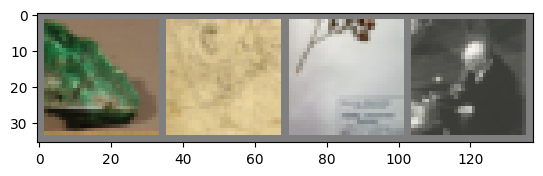

GroundTruth:  Минералогия Редкие книги Естественнонауч.коллекция Фото, негативы
Predict class - Графика, real class - Документы, probability (Археология,Графика) - tensor([ 0.1632,  0.8905,  0.6728,  0.1857,  0.5801, -2.5036, -1.3071,  0.8635,
         0.1991, -1.9970,  0.4064,  0.2637,  0.7925, -0.0811, -0.8011])
Predict class - Прочие, real class - Документы, probability (Археология,Графика) - tensor([ 0.3273, -0.3248,  0.2221, -0.1136,  0.6076, -1.5234, -0.7371,  0.3989,
         0.2797,  0.4737,  0.6685, -0.1141,  0.4798,  0.1653, -0.3354])
Predict class - Нумизматика, real class - Оружие, probability (Археология,Графика) - tensor([ 3.1554, -2.1302,  2.6904, -3.6473,  1.9274, -3.2867,  2.7883,  4.8099,
         0.0321, -3.1918,  2.1754,  0.0959,  1.4474,  1.0988, -5.4006])
Predict class - Скульптура, real class - Графика, probability (Археология,Графика) - tensor([ 2.7271, -0.7547,  2.9265, -3.4254,  1.2193, -2.2550,  1.7532,  1.3202,
         0.8561, -2.2454,  1.8951,  1.1459,  3.

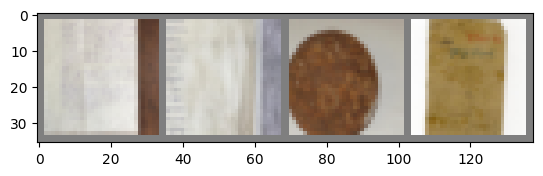

GroundTruth:  Графика Прочие Нумизматика Скульптура
Predict class - Живопись, real class - Живопись, probability (Археология,Графика) - tensor([-1.2375,  0.5728,  0.1795, -1.5268,  0.3834,  1.3719, -0.2714,  0.4484,
        -1.5045, -0.2172, -0.4669,  0.1170,  0.6645,  0.0194,  0.0307])
Predict class - Редкие книги, real class - Минералогия, probability (Археология,Графика) - tensor([-1.1057,  0.0273,  0.7062, -0.9884,  0.0341,  0.9883, -0.3217, -0.0547,
        -1.6335,  0.2926,  0.2284,  1.4502,  0.6991,  0.4919, -0.5695])
Predict class - Естественнонауч.коллекция, real class - Фото, негативы, probability (Археология,Графика) - tensor([-0.1520, -0.1478,  0.7101, -0.5910,  0.9377, -0.3480, -0.3764, -0.1134,
        -0.7117, -0.3287,  0.2038,  0.8853,  0.9208,  0.5162, -1.0774])
Predict class - Естественнонауч.коллекция, real class - Естественнонауч.коллекция, probability (Археология,Графика) - tensor([-0.1944, -0.5442,  0.1951, -1.4790,  1.2131, -0.4663,  0.5664, -0.3157,
        -0.3

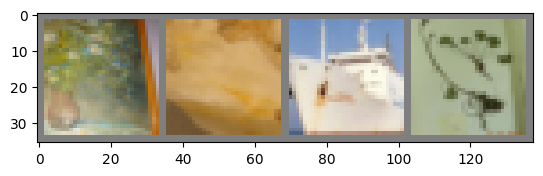

GroundTruth:  Живопись Редкие книги Естественнонауч.коллекция Естественнонауч.коллекция
Predict class - Естественнонауч.коллекция, real class - Фото, негативы, probability (Археология,Графика) - tensor([-0.1871, -0.8524, -0.1333, -2.8842,  2.2125, -1.0295,  1.3600, -0.3749,
        -1.5738, -0.7978,  0.8641, -1.1030,  1.3612,  0.6563,  2.1506])
Predict class - Печатная продукция, real class - Документы, probability (Археология,Графика) - tensor([-1.1686,  0.8801,  0.5859,  1.6309,  0.2916, -0.3386, -1.6180,  0.1239,
        -1.8116,  1.8367,  0.0152,  1.5391, -0.8132, -0.5682, -0.2319])
Predict class - Нумизматика, real class - Археология, probability (Археология,Графика) - tensor([ 1.2563,  0.2908,  0.5177, -0.2097,  0.1595, -0.7668, -2.4800,  1.7364,
        -0.6114,  1.1857,  1.0361,  0.1834, -0.2461,  0.9226, -1.8699])
Predict class - Графика, real class - Графика, probability (Археология,Графика) - tensor([ 0.1561,  2.8947,  1.1091, -0.7266,  1.8884, -3.3736, -1.4414,  0.0350,
   

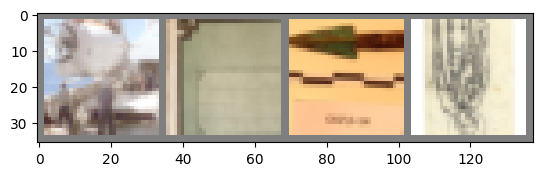

GroundTruth:  Естественнонауч.коллекция Печатная продукция Нумизматика Графика
Predict class - Печатная продукция, real class - Прочие, probability (Археология,Графика) - tensor([-0.6505, -0.5353,  0.6569, -1.5653,  0.2702,  0.8110, -0.0522, -0.0073,
        -0.8653,  0.8133,  0.6659,  0.2143,  0.0955,  0.7553, -0.1677])
Predict class - Нумизматика, real class - Нумизматика, probability (Археология,Графика) - tensor([-0.1016,  0.3954,  0.8995,  0.1397,  1.0184, -1.9750, -0.7790,  2.9177,
        -1.9800,  0.7293,  0.8986,  0.3732, -0.1796, -0.4037, -1.7026])
Predict class - Редкие книги, real class - Оружие, probability (Археология,Графика) - tensor([-1.4740, -0.5032,  0.7807, -0.1891, -0.9850,  0.0585,  0.1832,  0.9098,
        -1.8202,  1.5029,  0.7812,  1.5140, -0.1699,  0.0953, -0.1987])
Predict class - Скульптура, real class - Естественнонауч.коллекция, probability (Археология,Графика) - tensor([ 1.6821, -0.8162,  2.1490, -6.2249,  1.5473, -0.3225,  1.0756,  2.8440,
         0.500

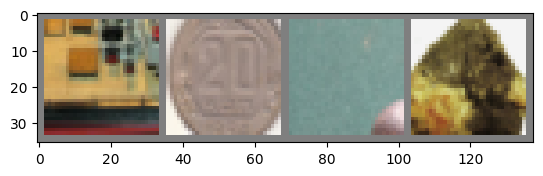

GroundTruth:  Печатная продукция Нумизматика Редкие книги Скульптура
Predict class - Живопись, real class - Нумизматика, probability (Археология,Графика) - tensor([-0.8062, -0.7155,  1.5378, -2.3012, -0.6870,  1.7934,  0.4275,  1.0354,
        -0.3931, -0.8942,  1.0189, -0.0174,  0.7219,  1.6654, -0.8855])
Predict class - Скульптура, real class - ДПИ, probability (Археология,Графика) - tensor([-0.8208, -0.2608,  0.9085, -1.5118, -0.2341,  0.9624,  0.1230,  0.1102,
        -0.3166, -0.5387,  0.4553, -0.2417,  1.2080,  0.8994, -0.2907])
Predict class - Живопись, real class - ДПИ, probability (Археология,Графика) - tensor([-1.5339, -0.1199,  0.7195, -2.3171,  0.2789,  1.8567,  0.1143, -0.2684,
        -0.9848, -0.5320,  0.0503,  0.4415,  0.9562,  0.4126, -0.0856])
Predict class - Живопись, real class - Минералогия, probability (Археология,Графика) - tensor([-0.6569, -0.2149,  0.4307, -0.9781,  0.4458,  0.7535,  0.1213, -0.0349,
        -1.1516,  0.4783,  0.2512,  0.2744,  0.2393,  0.2404,

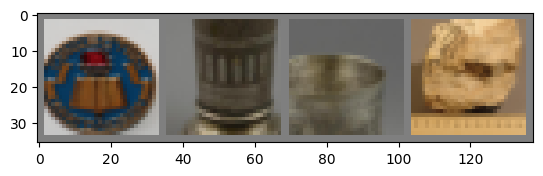

GroundTruth:  Живопись Скульптура Живопись Живопись
Predict class - Фото, негативы, real class - Скульптура, probability (Археология,Графика) - tensor([-2.8458, -0.3719, -0.1452, -1.8480, -1.2724,  0.0452, -0.0099, -0.3255,
        -1.4510,  0.3905,  0.8865,  0.1680,  1.6377,  1.7117,  3.1657])
Predict class - Нумизматика, real class - Печатная продукция, probability (Археология,Графика) - tensor([ 0.8672,  0.6030,  0.2610, -0.6100,  0.9836, -0.6149, -1.0865,  1.0279,
        -1.0359,  0.2947,  0.8842, -0.2475,  0.4655,  0.1349, -1.0547])
Predict class - Минералогия, real class - Оружие, probability (Археология,Графика) - tensor([ 0.5918, -1.5844,  1.6053, -1.7508,  1.3839, -0.6037,  1.6830, -0.1209,
         0.5491, -0.7155,  1.3042, -0.2211, -0.1456,  1.3181, -1.5266])
Predict class - Печатная продукция, real class - Археология, probability (Археология,Графика) - tensor([ 0.4062, -0.1561,  0.5010, -0.5535, -0.2105, -0.3259, -2.1547,  0.7093,
        -0.0061,  1.3540,  0.9105,  0.3330

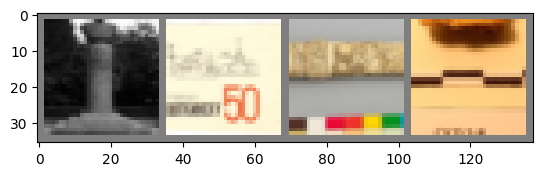

GroundTruth:  Фото, негативы Нумизматика Минералогия Печатная продукция
Predict class - Документы, real class - Печатная продукция, probability (Археология,Графика) - tensor([-1.0870,  1.1619,  0.1691,  1.4705,  0.3997, -0.1763, -1.5770, -0.3395,
        -1.4763,  1.3932, -0.1544,  0.7380, -0.7291, -0.3265,  0.1066])
Predict class - Естественнонауч.коллекция, real class - Естественнонауч.коллекция, probability (Археология,Графика) - tensor([ 1.7244, -1.1837,  0.4761, -2.7915,  2.0145, -1.6425, -0.6798, -0.7683,
         0.9235, -1.0047,  1.7494, -1.4529,  1.6355,  1.4955,  0.3443])
Predict class - Фото, негативы, real class - Живопись, probability (Археология,Графика) - tensor([-3.2847, -0.8435,  0.2172, -2.6612, -1.4462, -0.0930, -1.0330, -0.3766,
        -1.1639,  0.1974,  1.8479, -0.2388,  1.7163,  2.9445,  3.4786])
Predict class - ДПИ, real class - ДПИ, probability (Археология,Графика) - tensor([-1.0200, -0.2268,  1.3209, -0.7086,  0.7857,  0.6798,  0.2168, -0.6947,
        -0.9743

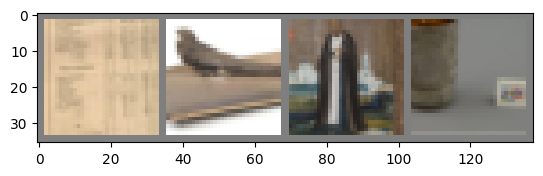

GroundTruth:  Документы Естественнонауч.коллекция Фото, негативы   ДПИ
Predict class - Редкие книги, real class - Оружие, probability (Археология,Графика) - tensor([-0.8524,  0.9813,  0.8187, -0.5554,  0.1469,  0.1813, -1.1869, -0.0517,
        -1.1229, -0.0891, -0.1171,  1.0503,  0.8083,  0.0824, -0.7903])
Predict class - Фото, негативы, real class - Техника, probability (Археология,Графика) - tensor([-1.5564, -1.0681,  0.2474, -1.5674, -0.2525,  1.1146,  0.9385, -0.9026,
        -0.7430,  0.3862,  0.7909,  0.3567,  0.1901,  1.0285,  1.7100])
Predict class - Археология, real class - Техника, probability (Археология,Графика) - tensor([ 5.3922, -2.7375,  0.9457, -3.9488,  3.1636, -3.9563, -2.5121, -1.4005,
         4.9010, -1.4508,  3.6495, -2.5500,  1.0450,  3.1507, -0.7185])
Predict class - Техника, real class - Прочие, probability (Археология,Графика) - tensor([ 0.0954, -1.9529,  2.2212, -3.4374,  1.4880, -2.2292,  0.6135, -0.5841,
         2.0974, -1.6637,  1.9193, -1.4612,  0.9546,

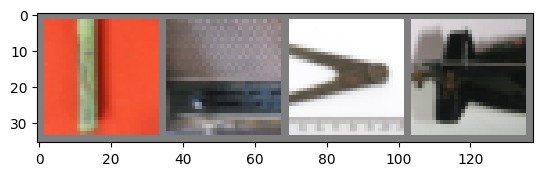

GroundTruth:  Редкие книги Фото, негативы Археология Техника
Predict class - Редкие книги, real class - Графика, probability (Археология,Графика) - tensor([-0.8456,  0.9389,  0.1555,  1.1157,  0.2883, -0.2270, -1.0176, -0.9012,
        -1.3286,  0.8971, -0.1144,  1.5704, -0.3010, -0.2451, -0.0191])
Predict class - Естественнонауч.коллекция, real class - Нумизматика, probability (Археология,Графика) - tensor([ 2.4209e+00, -3.8977e-01,  4.5271e-01, -5.2758e-04,  3.3057e+00,
        -4.1423e+00, -3.3774e-01,  2.9434e+00, -2.4870e+00, -1.2697e+00,
         1.1920e+00,  2.8041e+00,  1.1439e+00,  8.1070e-01, -3.5623e+00])
Predict class - Живопись, real class - Живопись, probability (Археология,Графика) - tensor([-2.1381, -0.1044,  0.4332, -1.0707, -0.5527,  1.6839, -0.5238, -0.5301,
        -0.8384,  0.2126, -0.0500,  0.6562,  0.3386,  0.8152,  0.6964])
Predict class - Редкие книги, real class - Археология, probability (Археология,Графика) - tensor([-0.9078, -0.1579,  1.4491, -0.3053, -0.335

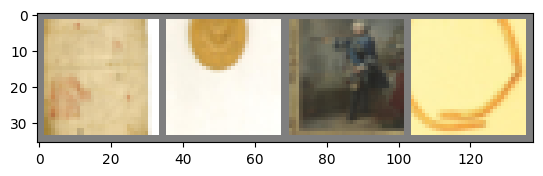

GroundTruth:  Редкие книги Естественнонауч.коллекция Живопись Редкие книги
Predict class - Редкие книги, real class - Фото, негативы, probability (Археология,Графика) - tensor([-1.6497, -1.1611,  1.4663, -1.8458, -0.4094,  0.5414, -0.2583,  0.1417,
        -0.8790,  0.9997,  0.9388,  1.6649, -0.0147,  0.9557, -0.4531])
Predict class - Нумизматика, real class - Естественнонауч.коллекция, probability (Археология,Графика) - tensor([ 0.4575,  0.1621,  1.2462, -1.8397,  1.2148, -0.8047, -0.1680,  2.0495,
        -1.4037, -0.2566,  0.7556, -0.5683,  1.1520,  0.7591, -1.6775])
Predict class - Редкие книги, real class - Печатная продукция, probability (Археология,Графика) - tensor([-0.2829,  0.4747,  0.3284,  0.2646,  0.0676, -1.4439, -1.0496, -0.2320,
        -0.5526, -0.2942,  0.1535,  1.6753,  0.5181, -0.1253,  0.0403])
Predict class - Прочие, real class - Скульптура, probability (Археология,Графика) - tensor([-0.4774, -1.4440,  1.4450, -1.4473, -0.1991, -0.7033,  0.3640,  0.1992,
        -

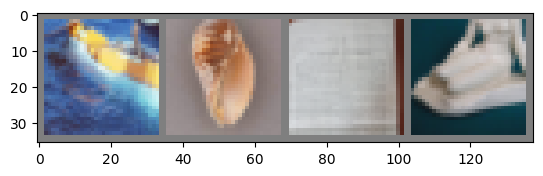

GroundTruth:  Редкие книги Нумизматика Редкие книги Прочие
Predict class - Редкие книги, real class - Минералогия, probability (Археология,Графика) - tensor([-0.6798, -0.1721,  0.6261, -1.3152,  0.2496,  1.0798,  0.0209,  0.3880,
        -1.3643, -0.1303,  0.0731,  1.1750,  0.4856,  0.1958, -0.6686])
Predict class - Редкие книги, real class - Печатная продукция, probability (Археология,Графика) - tensor([-1.0502,  0.4504, -0.3986,  3.0604, -0.6685, -1.8614, -3.2143, -0.5107,
        -0.5256,  2.7530,  1.3458,  3.3598, -1.3296, -0.4306, -0.4489])
Predict class - Техника, real class - Оружие, probability (Археология,Графика) - tensor([-1.4770, -0.5229,  0.3194, -1.3229, -0.1134, -0.1118, -0.3082, -0.5144,
        -0.2673, -0.7474,  0.7076, -0.4072,  1.1235,  1.6839,  1.3723])
Predict class - Редкие книги, real class - Техника, probability (Археология,Графика) - tensor([-1.0702, -0.0134,  1.0823, -2.1910, -0.1118,  1.7344, -0.5628,  0.0146,
        -1.6073, -0.7364,  0.0064,  2.9821,  1.2

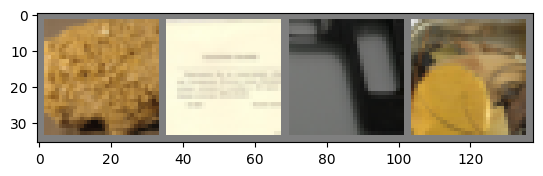

GroundTruth:  Редкие книги Редкие книги Техника Редкие книги
Predict class - Фото, негативы, real class - Фото, негативы, probability (Археология,Графика) - tensor([-0.1533, -2.1898,  0.4342, -1.3747,  0.3554, -0.3020,  0.1600, -1.2756,
         1.1539, -0.3267,  1.8154, -0.0450, -0.3213,  1.5185,  2.8077])
Predict class - Редкие книги, real class - Нумизматика, probability (Археология,Графика) - tensor([-0.4561,  0.2150,  0.5520, -0.4383, -0.4897,  0.1843, -0.6805,  1.0994,
        -1.6556,  0.6905,  0.0045,  1.6140, -0.1729, -0.0747, -0.5848])
Predict class - ДПИ, real class - Печатная продукция, probability (Археология,Графика) - tensor([-1.0151, -0.1069,  0.8469, -0.9282,  0.6491,  0.8355, -0.4974, -0.6203,
        -0.7760,  0.6708,  0.3617,  0.3664, -0.2466,  0.4917, -0.1174])
Predict class - Фото, негативы, real class - Прочие, probability (Археология,Графика) - tensor([-2.5198, -0.3487, -0.0576, -1.5396, -0.9148,  1.3189,  0.8307, -0.2321,
        -1.7229,  0.3884,  0.4384,  0.4

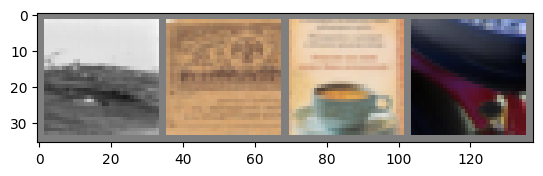

GroundTruth:  Фото, негативы Редкие книги   ДПИ Фото, негативы
Predict class - Живопись, real class - Скульптура, probability (Археология,Графика) - tensor([-2.3255,  0.4623,  0.1839, -2.8587, -0.3221,  3.4783, -0.6291,  0.2939,
        -1.1511, -0.7515,  0.1059, -0.0677,  1.2719,  0.4106,  0.0786])
Predict class - Оружие, real class - Археология, probability (Археология,Графика) - tensor([ 0.2039, -0.5678,  1.3178, -1.1984,  0.9929, -1.0231, -2.4848, -0.5167,
         1.8463,  0.7021,  1.2594,  0.2051, -0.6649,  1.4548, -0.2206])
Predict class - Живопись, real class - Графика, probability (Археология,Графика) - tensor([-1.5766,  0.2677,  0.1655, -1.0172, -0.1755,  1.4614, -0.0433, -0.0970,
        -1.3141,  0.2252, -0.0285,  0.4266,  0.5273,  0.1258,  0.4351])
Predict class - Минералогия, real class - Минералогия, probability (Археология,Графика) - tensor([-0.7104, -0.6588,  0.7408, -0.7838, -0.1656,  0.3130,  1.4236, -0.0403,
        -0.3354, -0.2169,  0.4194,  0.3021, -0.1995,  0.79

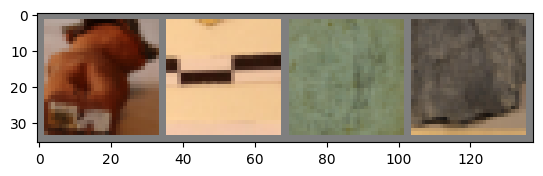

GroundTruth:  Живопись Оружие Живопись Минералогия
Predict class - Техника, real class - Живопись, probability (Археология,Графика) - tensor([-1.8615, -1.2518,  1.0628, -2.9640,  0.8515,  0.1447,  0.3892, -1.1361,
        -0.6465, -0.8738,  1.2116, -0.0653,  1.4971,  1.6713,  1.4725])
Predict class - Нумизматика, real class - Нумизматика, probability (Археология,Графика) - tensor([-0.0539,  1.1656,  0.4007, -0.5456, -0.1203, -0.4869, -1.4716,  1.8466,
        -1.7023,  0.7408,  0.3321,  0.5827, -0.3109,  0.0976, -0.6753])
Predict class - Живопись, real class - Минералогия, probability (Археология,Графика) - tensor([-0.2970, -0.5464,  0.7327, -1.9516,  0.5705,  0.8644,  0.3090,  0.5567,
        -0.7989, -0.3249,  0.5595, -0.4103,  0.6627,  0.5970, -0.6129])
Predict class - Скульптура, real class - Оружие, probability (Археология,Графика) - tensor([-0.9791, -0.3667,  1.1902, -2.3728,  0.2868,  1.2167, -0.4074,  0.0335,
        -0.4816, -0.6836, -0.0247, -0.0813,  1.2205,  0.8251, -0.5605

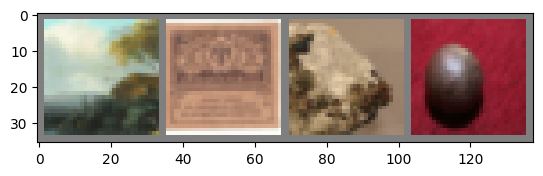

GroundTruth:  Техника Нумизматика Живопись Скульптура
Predict class - Прочие, real class - Естественнонауч.коллекция, probability (Археология,Графика) - tensor([ 1.2377,  1.0806, -0.2556,  0.0998,  1.0623, -2.5406, -2.0455,  0.4345,
        -0.4966,  0.5690,  1.6388,  0.5811,  0.4680, -0.1994, -0.4930])
Predict class - Редкие книги, real class - Минералогия, probability (Археология,Графика) - tensor([-1.1770,  0.4496,  0.6154,  0.7821,  0.2388,  0.2568, -0.5953, -0.6761,
        -1.8832,  0.8936, -0.0983,  1.9823,  0.0750, -0.2247, -0.4183])
Predict class - Живопись, real class - Минералогия, probability (Археология,Графика) - tensor([-1.3336,  0.1397,  0.2424, -1.7130,  0.4445,  0.9375,  0.1024, -0.2558,
        -1.5546,  0.2567,  0.1311,  0.0473,  0.8707,  0.2216,  0.8382])
Predict class - Техника, real class - Прочие, probability (Археология,Графика) - tensor([-0.8803, -0.8740,  1.1933, -1.5183, -0.2978,  1.1673, -0.6395, -0.1081,
        -0.1422,  0.0660,  0.8505,  0.5240,  0.0817,

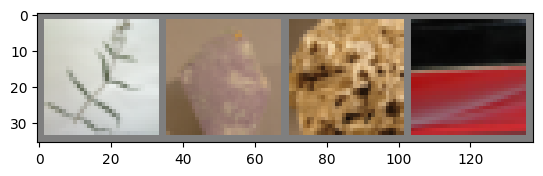

GroundTruth:  Прочие Редкие книги Живопись Техника
Predict class - Техника, real class - Печатная продукция, probability (Археология,Графика) - tensor([-0.3005, -0.9762,  1.1078, -0.2721,  0.9099, -0.0865, -1.1051, -0.1539,
         0.1650, -0.1643,  0.3210,  0.8781,  0.4347,  1.1157, -0.9944])
Predict class - Живопись, real class - Печатная продукция, probability (Археология,Графика) - tensor([-0.8360, -0.0981,  0.5290, -0.4494, -0.6837,  0.7899, -0.6784,  0.5655,
        -0.9944,  0.7353,  0.2618,  0.7373, -0.0642,  0.5123, -0.2254])
Predict class - Скульптура, real class - Археология, probability (Археология,Графика) - tensor([-1.6221,  0.0624,  1.0448, -2.3393, -0.1211,  0.6474, -1.0305,  0.0052,
        -0.3086, -0.5591,  0.3490, -1.0916,  2.2160,  1.2948, -0.1069])
Predict class - Техника, real class - Техника, probability (Археология,Графика) - tensor([-1.7331, -0.8695,  0.4940, -1.3430, -0.3593,  0.6841,  0.9303, -0.5424,
        -0.8394,  0.0168,  1.1689,  0.3436,  0.3712,  1.

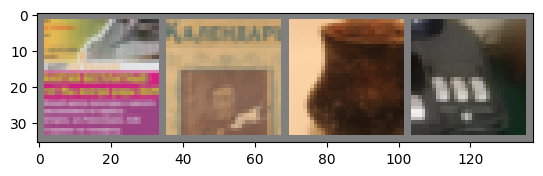

GroundTruth:  Техника Живопись Скульптура Техника
Predict class - Живопись, real class - Живопись, probability (Археология,Графика) - tensor([-1.1352, -0.3555,  0.7753, -1.2184,  0.0938,  1.3920,  1.2008, -0.5103,
        -0.8659, -0.4580,  0.4427,  0.5752,  0.2734,  0.5575, -0.0305])
Predict class - Печатная продукция, real class - Археология, probability (Археология,Графика) - tensor([ 0.6460,  0.1604,  0.6573, -0.6268,  0.1329, -0.1557, -2.4273,  0.9197,
        -0.2867,  1.5186,  0.8505,  0.2245, -0.2874,  0.9779, -1.2505])
Predict class - ДПИ, real class - ДПИ, probability (Археология,Графика) - tensor([-0.4945, -0.4495,  1.1503, -1.5084,  0.3647,  0.3436,  0.9550,  0.2654,
        -0.7313, -0.0768,  0.0652,  0.1045,  0.3237,  0.4991, -0.3981])
Predict class - Оружие, real class - Оружие, probability (Археология,Графика) - tensor([ 1.5838, -3.4970,  1.9997, -2.6085,  1.6201, -2.9933, -2.5020, -1.4151,
         5.8914, -2.2434,  2.3750,  0.1307,  0.9220,  3.9200, -0.2185])


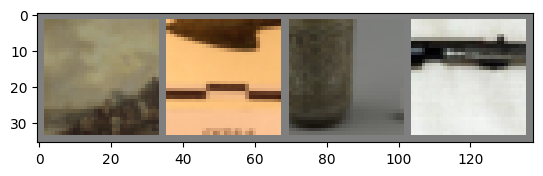

GroundTruth:  Живопись Печатная продукция   ДПИ Оружие
Predict class - Живопись, real class - Живопись, probability (Археология,Графика) - tensor([-0.5701,  0.0621,  0.5762, -1.7331, -0.1499,  1.1807, -0.0771,  1.1612,
        -1.3250, -0.1989,  0.2279,  0.4648,  0.7167,  0.1983, -0.6538])
Predict class - Редкие книги, real class - Оружие, probability (Археология,Графика) - tensor([-0.8148, -0.5187,  1.3504, -1.0899, -0.3837,  0.5923, -0.8787, -0.4351,
        -0.3261, -0.1241,  0.0293,  2.0171,  0.7580,  0.5488, -1.2761])
Predict class - Печатная продукция, real class - Редкие книги, probability (Археология,Графика) - tensor([ 1.1485,  0.2391, -0.5752,  0.9524,  0.3971, -2.1935, -2.6203,  0.2315,
        -0.3606,  2.2355,  1.7324,  1.3935, -0.2122, -0.1223, -0.5125])
Predict class - Техника, real class - Минералогия, probability (Археология,Графика) - tensor([-1.0732, -1.1103,  0.4027, -1.8062, -0.0420,  0.1838,  1.0539, -1.1605,
        -0.0658,  0.3474,  1.0083, -0.1272,  0.1067,  1

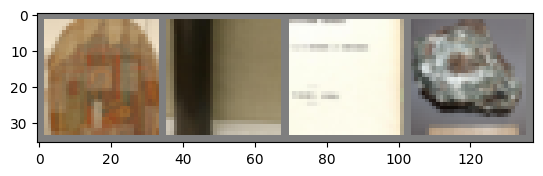

GroundTruth:  Живопись Редкие книги Печатная продукция Техника
Predict class - Оружие, real class - Техника, probability (Археология,Графика) - tensor([ 3.8613, -4.7451,  2.3839, -3.4497,  1.5498, -5.9635, -5.7401, -1.7550,
         8.6130, -0.8765,  3.6212, -1.2748,  1.2108,  4.2984,  0.3699])
Predict class - Печатная продукция, real class - Археология, probability (Археология,Графика) - tensor([ 0.5348, -0.1630,  0.4359, -1.3634,  0.0412,  0.0550, -1.9354,  0.5103,
        -0.4348,  1.3965,  1.0521,  0.1421,  0.1281,  0.9532, -0.6328])
Predict class - Живопись, real class - Живопись, probability (Археология,Графика) - tensor([-1.8443, -0.0247,  0.5000, -2.3069, -0.0969,  2.4513, -0.3943, -0.1078,
        -1.1434, -0.4943,  0.3249,  0.4547,  1.0525,  0.6945,  0.0317])
Predict class - Естественнонауч.коллекция, real class - Печатная продукция, probability (Археология,Графика) - tensor([ 0.4794, -0.6393,  0.3233, -1.3129,  0.9265, -0.1529,  0.3645,  0.4779,
        -0.9681,  0.1304,  0.

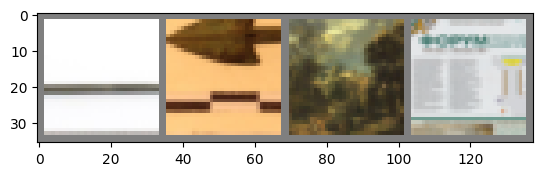

GroundTruth:  Оружие Печатная продукция Живопись Естественнонауч.коллекция
Predict class - Естественнонауч.коллекция, real class - Естественнонауч.коллекция, probability (Археология,Графика) - tensor([ 9.5241e-01, -7.1077e-01,  8.2261e-01, -2.1055e+00,  2.1342e+00,
        -2.0347e+00,  3.6910e-01,  1.5093e-03,  6.3088e-01, -1.0064e+00,
         6.8957e-01, -1.2531e+00,  4.6178e-01,  1.1639e+00, -4.2492e-02])
Predict class - Прочие, real class - Редкие книги, probability (Археология,Графика) - tensor([-0.3629,  1.0187,  1.1156, -2.0971, -0.2395, -0.0958, -0.1643,  2.2254,
        -2.8130,  0.0623,  2.2587,  0.8398,  0.9330,  0.8182, -1.0467])
Predict class - Живопись, real class - Живопись, probability (Археология,Графика) - tensor([-2.7712,  0.8066,  1.0918, -3.9901, -0.2284,  2.9930, -1.5117,  0.5493,
        -1.8409, -0.2970,  0.2972,  0.0117,  1.8572,  1.2959,  0.0749])
Predict class - Нумизматика, real class - Нумизматика, probability (Археология,Графика) - tensor([ 3.2270, -0.856

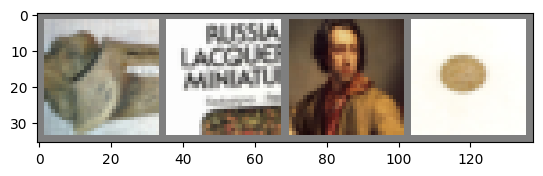

GroundTruth:  Естественнонауч.коллекция Прочие Живопись Нумизматика
Predict class - Редкие книги, real class - Документы, probability (Археология,Графика) - tensor([-2.0821,  4.0937,  0.2213,  4.6758, -0.9005, -2.2650, -3.5408, -2.5583,
        -1.5976, -1.2800,  0.0886,  5.2347,  1.2643, -0.7099, -2.4157])
Predict class - Живопись, real class - Археология, probability (Археология,Графика) - tensor([-1.1105, -0.0529,  0.7138, -1.9157, -0.6805,  2.4337, -1.0519,  1.0011,
        -1.0121, -0.4001,  0.1819,  1.1192,  0.5198,  0.3825, -0.9064])
Predict class - Графика, real class - Графика, probability (Археология,Графика) - tensor([-0.7796,  1.3222,  0.2258,  0.0390, -0.0971,  0.0970, -0.8414,  0.7028,
        -2.0871,  1.0821, -0.1673,  1.2079, -0.1781, -0.0529, -0.0986])
Predict class - Печатная продукция, real class - Нумизматика, probability (Археология,Графика) - tensor([-1.2096,  0.7914,  0.3474, -0.1861,  0.1091,  0.1523, -0.5865,  0.8723,
        -2.2367,  1.2673, -0.0630,  1.0674

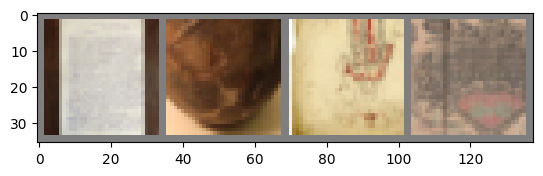

GroundTruth:  Редкие книги Живопись Графика Печатная продукция
Predict class - Живопись, real class - Археология, probability (Археология,Графика) - tensor([-2.5865,  0.5883,  0.3940, -3.2009, -0.5263,  3.4218, -0.9521,  0.3584,
        -1.4920, -0.5049,  0.1393,  0.3767,  1.3343,  0.7305,  0.1875])
Predict class - Графика, real class - Печатная продукция, probability (Археология,Графика) - tensor([-0.9807,  1.5785,  0.0680,  0.9661,  0.5370, -0.4742, -0.9224, -0.9826,
        -1.4595,  0.9920, -0.0838,  1.2862, -0.3267, -0.4204,  0.0278])
Predict class - Скульптура, real class - Живопись, probability (Археология,Графика) - tensor([-1.1836, -0.1891,  0.5707, -1.4853,  0.6732,  0.5858, -0.6338, -0.5169,
        -0.6078, -0.2384,  0.3538, -0.6011,  0.8109,  0.7659,  0.3529])
Predict class - Редкие книги, real class - Редкие книги, probability (Археология,Графика) - tensor([-1.3545,  1.3687,  0.1191,  2.3106, -0.4810, -0.5397, -2.3798, -0.8584,
        -1.3733,  2.0434,  0.1996,  2.5371, 

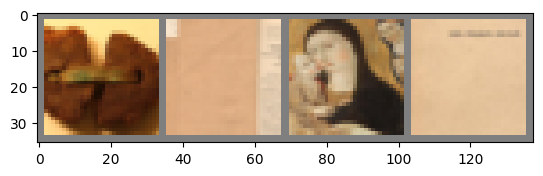

GroundTruth:  Живопись Графика Скульптура Редкие книги
Predict class - Живопись, real class - Минералогия, probability (Археология,Графика) - tensor([-2.0580,  0.2727,  0.4185, -2.3736, -0.3630,  2.5527, -0.6007,  0.2403,
        -1.3790, -0.1947,  0.1316,  0.2630,  1.0064,  0.6800,  0.2967])
Predict class - Нумизматика, real class - ДПИ, probability (Археология,Графика) - tensor([ 2.7522, -0.2757,  1.2310,  0.1563,  3.8457, -3.9369, -2.0430,  4.0189,
        -1.3089, -2.4216,  1.0758, -1.3834,  0.8487,  0.5763, -3.0134])
Predict class - Нумизматика, real class - ДПИ, probability (Археология,Графика) - tensor([-0.1731, -0.5610,  0.7877, -0.8816, -0.5651,  0.6166,  0.4623,  1.7856,
        -0.5383, -0.3659,  0.6912, -0.0380, -0.1188,  0.4879, -0.6371])
Predict class - Нумизматика, real class - Археология, probability (Археология,Графика) - tensor([ 1.1557e+00,  3.0967e-01,  3.6633e-01, -5.9896e-01,  6.9010e-01,
        -4.7539e-01, -1.5162e+00,  1.2285e+00, -6.6360e-01,  6.8200e-01,
   

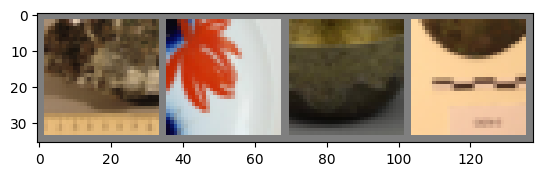

GroundTruth:  Живопись Нумизматика Нумизматика Нумизматика
Predict class - Минералогия, real class - Естественнонауч.коллекция, probability (Археология,Графика) - tensor([-0.1247, -0.9326,  0.9986, -1.2355,  0.2679, -0.0838,  1.5221, -0.5340,
         0.3530, -0.2172,  0.6409, -0.0359, -0.4623,  1.1341, -0.2031])
Predict class - Печатная продукция, real class - Редкие книги, probability (Археология,Графика) - tensor([-0.4093,  0.5409, -0.3186,  1.2090,  0.6266, -0.8649, -1.0172, -0.5706,
        -0.9635,  1.5151,  0.4532,  0.8999, -0.3577, -0.3509,  0.0399])
Predict class - ДПИ, real class - Минералогия, probability (Археология,Графика) - tensor([-1.1135e+00, -2.6533e-01,  1.3130e+00, -2.8464e-01, -6.3983e-02,
         9.5046e-01,  2.7797e-01, -4.3651e-01, -1.2500e+00,  2.3956e-01,
         6.4968e-01,  1.2625e+00, -1.4897e-04,  8.8710e-01, -7.9215e-01])
Predict class - Оружие, real class - Техника, probability (Археология,Графика) - tensor([ 1.7645, -2.6449,  1.3785, -1.7081,  1.7681,

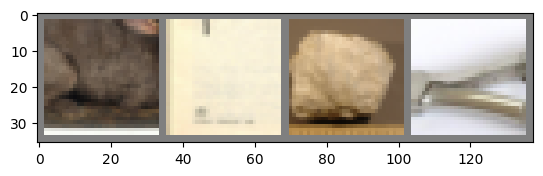

GroundTruth:  Минералогия Печатная продукция   ДПИ Оружие
Predict class - Живопись, real class - Живопись, probability (Археология,Графика) - tensor([-1.6006,  0.0210,  0.9251, -2.8445, -0.3915,  2.9409, -0.9614,  0.2399,
        -1.2498, -0.5739,  0.4855,  1.3541,  1.1170,  0.6104, -0.9853])
Predict class - Скульптура, real class - Прочие, probability (Археология,Графика) - tensor([ 0.4615,  0.4303, -0.0363, -1.6879, -0.2771, -0.7314, -1.3662,  1.1231,
        -1.2162, -0.0905,  0.6810,  0.4170,  1.4889,  0.1392, -0.0084])
Predict class - Редкие книги, real class - Скульптура, probability (Археология,Графика) - tensor([-0.3451,  0.0490,  0.7248, -0.5323,  0.5986, -0.0691, -0.3564,  0.5030,
        -1.8603,  0.4311, -0.0117,  1.7604,  0.4692, -0.1615, -0.9054])
Predict class - Техника, real class - Редкие книги, probability (Археология,Графика) - tensor([-0.0796,  0.9039,  1.6189, -1.8397,  0.9478, -2.9459, -1.0802, -1.6284,
         1.2987, -1.0687,  1.8273, -0.8583,  1.7863,  2.2575,

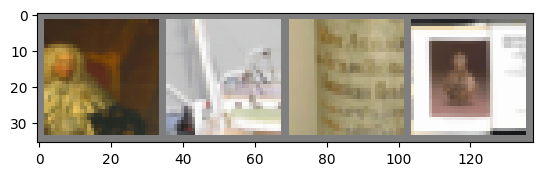

GroundTruth:  Живопись Скульптура Редкие книги Техника
Predict class - Оружие, real class - Оружие, probability (Археология,Графика) - tensor([ 1.8127, -3.0741,  3.2840, -3.2348,  2.1149, -2.6301, -1.1197, -3.1276,
         5.2171, -0.9346,  2.7993, -0.2988, -1.7051,  3.0885, -0.3226])
Predict class - Редкие книги, real class - Графика, probability (Археология,Графика) - tensor([-0.8487,  0.3582,  0.3086,  0.6234, -0.2640,  0.2519, -0.7826,  0.1648,
        -1.3301,  0.9898, -0.0643,  1.1881, -0.3668,  0.0204, -0.0705])
Predict class - Живопись, real class - Естественнонауч.коллекция, probability (Археология,Графика) - tensor([-0.6304,  0.0298,  0.4986, -1.5654,  0.7499,  1.1073,  0.5739,  0.3200,
        -1.1712, -0.4300,  0.0923,  0.0659,  0.3827,  0.0305, -0.4957])
Predict class - ДПИ, real class - Печатная продукция, probability (Археология,Графика) - tensor([-0.0602, -0.0526,  0.9992, -0.6526,  0.4207,  0.2734,  0.0035,  0.4952,
        -0.8368,  0.5698,  0.4084,  0.1030, -0.2632,

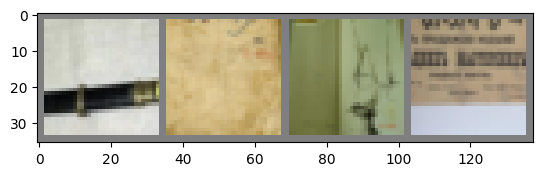

GroundTruth:  Оружие Редкие книги Живопись   ДПИ
Predict class - Скульптура, real class - Оружие, probability (Археология,Графика) - tensor([-1.2120, -0.3348,  0.3192, -1.0241, -0.0957,  0.4204, -0.2642, -0.5292,
        -0.2242, -0.5284,  0.3212, -0.2648,  1.0986,  0.9449,  0.4861])
Predict class - ДПИ, real class - ДПИ, probability (Археология,Графика) - tensor([ 0.0993, -0.7390,  2.7145, -2.1774,  1.2077, -1.1156,  1.1956,  0.4451,
         0.0991, -0.3509,  0.7190, -0.9193,  0.3413,  1.3272, -1.6730])
Predict class - Оружие, real class - Документы, probability (Археология,Графика) - tensor([-0.6775, -1.4268,  0.9105,  1.1819, -0.3633, -1.4018, -1.8493, -1.4705,
         4.0310,  0.6399,  1.3987,  2.0772, -0.7822,  1.6205, -1.3344])
Predict class - Нумизматика, real class - ДПИ, probability (Археология,Графика) - tensor([ 0.7030, -1.2643,  1.3640, -1.0541,  0.1456, -0.7739,  1.4313,  1.4774,
        -0.2043, -0.6255,  0.8308,  0.5888, -0.1569,  0.7684, -1.4673])


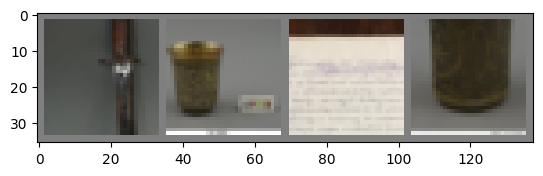

GroundTruth:  Скульптура   ДПИ Оружие Нумизматика
Predict class - Археология, real class - Техника, probability (Археология,Графика) - tensor([ 2.6499, -0.3400, -0.5247, -1.2869,  0.3353, -1.3412, -2.9916,  1.2277,
        -0.0998,  1.0300,  1.8834,  0.4707,  0.9913,  0.2726, -1.0102])
Predict class - Археология, real class - Печатная продукция, probability (Археология,Графика) - tensor([ 1.5510, -0.4298, -0.4059, -0.0803, -0.0280, -2.0124, -2.1849,  0.4947,
         0.6069,  1.5280,  1.4527,  0.5377,  0.1004,  0.2403, -0.0181])
Predict class - Печатная продукция, real class - Редкие книги, probability (Археология,Графика) - tensor([-2.1539, -0.0502,  0.7549,  3.4334, -1.3420, -0.4141, -2.4915,  0.0419,
        -2.2511,  3.7224,  1.9976,  2.7333, -1.7495, -0.9429, -0.0735])
Predict class - Фото, негативы, real class - Техника, probability (Археология,Графика) - tensor([-1.5474,  0.1795,  0.3819, -1.4140, -0.7990,  0.2889,  0.0738,  0.5701,
        -1.6757,  0.8319,  0.1470,  0.0962,  0

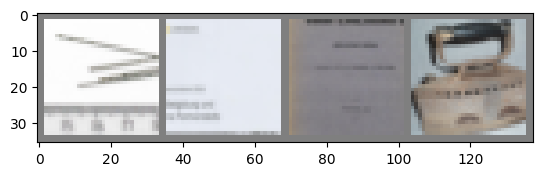

GroundTruth:  Археология Археология Печатная продукция Фото, негативы
Predict class - Техника, real class - Скульптура, probability (Археология,Графика) - tensor([-2.4343, -0.5694,  0.7855, -1.2216, -0.9154,  1.1326, -0.6445, -0.4728,
        -0.5695,  0.3289,  0.1341,  0.5682,  0.4906,  1.3035,  1.2896])
Predict class - Печатная продукция, real class - Печатная продукция, probability (Археология,Графика) - tensor([-1.8180, -0.3584,  1.1405,  1.8490, -0.9586, -0.0385, -1.4857,  0.0633,
        -1.2577,  2.6025,  1.2713,  1.9049, -1.2016, -0.3077, -0.3191])
Predict class - Скульптура, real class - Скульптура, probability (Археология,Графика) - tensor([-1.3063,  0.0629,  0.9964, -2.8532,  0.9064,  0.6078,  0.2272, -0.3089,
        -0.7632, -0.8376,  0.1812, -0.9864,  1.6886,  0.6126,  0.3935])
Predict class - Печатная продукция, real class - Нумизматика, probability (Археология,Графика) - tensor([-1.8170,  1.5427,  0.4041,  0.5296,  0.6578, -0.9586, -1.5803,  0.2725,
        -2.2724,  1.

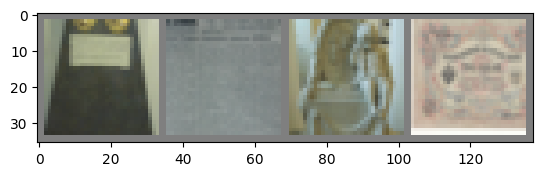

GroundTruth:  Техника Печатная продукция Скульптура Печатная продукция
Predict class - Живопись, real class - Живопись, probability (Археология,Графика) - tensor([-1.9921,  0.3321,  0.3451, -2.2593, -0.3067,  2.9632,  0.0196, -0.4290,
        -1.1401, -0.2331,  0.0658,  0.9051,  0.3651,  0.3026,  0.0037])
Predict class - Техника, real class - Оружие, probability (Археология,Графика) - tensor([-1.5480, -1.4362,  1.0208, -2.9493,  0.4238,  0.8445,  0.7685, -1.5825,
        -0.0168,  0.6462,  2.0427,  0.5116, -0.2069,  2.0945,  0.4791])
Predict class - Нумизматика, real class - Нумизматика, probability (Археология,Графика) - tensor([ 3.8639, -1.2381,  1.5537, -3.8089,  3.6582, -5.3425, -0.7104,  5.4815,
         2.0736, -3.3548,  2.2051, -4.8946,  3.3848,  2.2724, -4.0801])
Predict class - Естественнонауч.коллекция, real class - Естественнонауч.коллекция, probability (Археология,Графика) - tensor([ 1.0177, -1.2839,  1.4647, -0.8242,  1.7195, -1.1010,  0.4451,  0.6034,
         0.2597, -0.

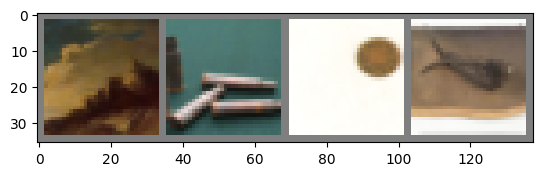

GroundTruth:  Живопись Техника Нумизматика Естественнонауч.коллекция
Predict class - Минералогия, real class - Естественнонауч.коллекция, probability (Археология,Графика) - tensor([ 1.9463, -0.9062,  1.5577, -3.5754,  2.0066, -1.7474,  3.0763,  1.1047,
         0.4409, -2.3346,  1.4123, -2.6822,  2.8288,  1.4791, -1.9803])
Predict class - Графика, real class - Графика, probability (Археология,Графика) - tensor([-1.4385,  1.4309,  0.5186, -0.1642,  0.6173,  0.0963, -1.5276,  0.0093,
        -1.7416,  0.6773,  0.0879,  0.3296,  0.3603,  0.1163, -0.1089])
Predict class - Редкие книги, real class - Техника, probability (Археология,Графика) - tensor([-2.2324, -0.2620,  0.9186, -0.2709, -0.4082,  1.6668,  1.1098, -1.1448,
        -2.0874, -0.0570,  0.7289,  2.1014,  0.4407,  0.7740, -0.1004])
Predict class - Редкие книги, real class - Живопись, probability (Археология,Графика) - tensor([-0.8589, -0.5854,  1.2612, -2.2693, -0.3727,  2.0701, -0.4731,  0.5088,
        -0.8664, -0.8106,  0.3124,

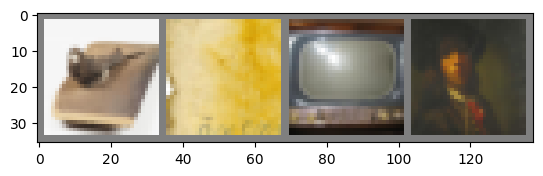

GroundTruth:  Минералогия Графика Редкие книги Редкие книги
Predict class - Техника, real class - Оружие, probability (Археология,Графика) - tensor([-1.7347, -0.9805,  0.9314, -1.4982, -1.1864,  0.1858,  0.3995,  0.9493,
        -1.3066,  0.8929,  0.4640,  1.0590,  0.4393,  1.3835,  0.8076])
Predict class - ДПИ, real class - ДПИ, probability (Археология,Графика) - tensor([-0.8543,  0.0792,  2.6285, -2.5399,  0.4704,  0.0548,  0.7962,  0.1428,
        -0.2880,  0.1094,  0.3527, -0.3912,  0.2388,  1.1137, -1.1718])
Predict class - Техника, real class - Оружие, probability (Археология,Графика) - tensor([-1.2963, -1.8797,  0.6529, -2.6623, -0.1210, -1.7792,  1.9758, -0.6488,
        -0.3628, -0.1258,  2.4801, -0.4350,  1.0941,  2.9952,  2.2731])
Predict class - Живопись, real class - Документы, probability (Археология,Графика) - tensor([-1.4213,  0.2593,  0.1509, -0.8181, -0.6178,  1.5006, -0.3934,  0.5161,
        -1.5073,  0.5512,  0.0535,  1.0603,  0.0812, -0.0022,  0.1512])


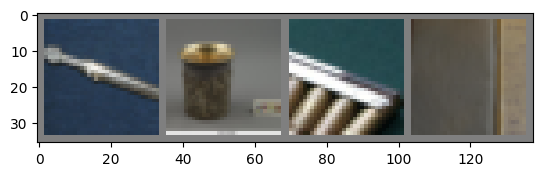

GroundTruth:  Техника   ДПИ Техника Живопись
Predict class - ДПИ, real class - Минералогия, probability (Археология,Графика) - tensor([-0.3664, -0.4260,  0.9611, -0.8611,  0.3819,  0.6682,  0.7009,  0.0825,
        -0.8855,  0.2267,  0.4542,  0.7164, -0.2363,  0.5299, -0.9182])
Predict class - Редкие книги, real class - Редкие книги, probability (Археология,Графика) - tensor([-1.5468,  1.8537,  0.1855,  2.6666, -0.7470, -0.9411, -2.4136, -1.2766,
        -1.9382,  1.4462,  0.0298,  4.1680, -0.7981, -0.4811, -0.3882])
Predict class - Скульптура, real class - Скульптура, probability (Археология,Графика) - tensor([-0.6141,  0.2488,  1.6383, -3.5336, -0.2420,  1.4675, -0.7919,  1.5241,
        -0.7387, -0.8027,  0.6909, -0.4328,  2.1020,  1.2533, -1.6350])
Predict class - Печатная продукция, real class - Археология, probability (Археология,Графика) - tensor([ 0.2261,  0.0060,  0.5150,  0.0427,  0.1525, -0.2378, -1.4292,  0.5622,
        -0.2914,  1.1820,  0.3911,  0.3743, -0.4896,  0.6089,

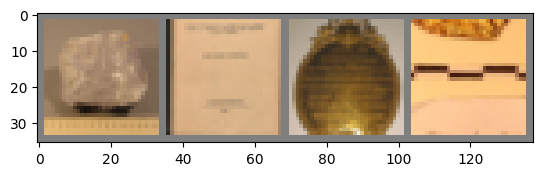

GroundTruth:    ДПИ Редкие книги Скульптура Печатная продукция
Predict class - Фото, негативы, real class - Оружие, probability (Археология,Графика) - tensor([-0.4879, -1.1404,  0.3717, -2.0937,  0.8009, -2.1149, -0.9146, -0.4051,
         0.1763, -1.1397,  1.0034, -0.5744,  1.5202,  1.8399,  1.9048])
Predict class - Живопись, real class - Естественнонауч.коллекция, probability (Археология,Графика) - tensor([-1.2510,  0.1900,  0.3817, -1.1104, -0.2298,  1.5136,  0.2978, -0.0932,
        -1.4560,  0.1225, -0.1064,  1.0630,  0.3876,  0.2007,  0.1058])
Predict class - Редкие книги, real class - Документы, probability (Археология,Графика) - tensor([-1.6343,  3.0065, -0.1674,  3.1266,  0.0771, -1.7514, -2.2067, -1.9738,
        -1.9575,  0.3190,  0.0598,  3.7695,  0.4297, -0.8431, -0.9476])
Predict class - Скульптура, real class - Графика, probability (Археология,Графика) - tensor([ 0.2807, -0.6201,  1.1273, -1.7721,  0.6223, -0.5057,  0.0683, -0.6954,
         1.0881, -1.3944,  1.1012, -1.

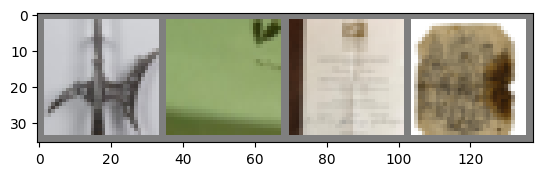

GroundTruth:  Фото, негативы Живопись Редкие книги Скульптура
Predict class - Графика, real class - Документы, probability (Археология,Графика) - tensor([-1.0160,  2.0966,  0.0284,  1.3910,  0.8863, -1.4602, -1.9184,  0.1856,
        -0.9713, -0.2858, -0.0125, -0.1104,  0.0897, -0.5995, -0.2737])
Predict class - Редкие книги, real class - Скульптура, probability (Археология,Графика) - tensor([-1.0225,  0.4112,  0.3265,  0.0212,  0.0148,  0.4832, -0.6847,  0.2174,
        -1.7874,  0.9083, -0.0698,  1.3147, -0.0536, -0.1497,  0.0044])
Predict class - Скульптура, real class - Редкие книги, probability (Археология,Графика) - tensor([ 0.2143,  1.7785,  0.8185, -2.3708,  1.7600, -2.4150, -2.4625,  1.3761,
        -0.3338, -1.6635,  1.2187, -1.3752,  2.5903,  0.5316, -1.4648])
Predict class - Фото, негативы, real class - Прочие, probability (Археология,Графика) - tensor([-0.3823, -1.0271,  0.2769, -1.6476,  0.3256,  0.1572, -0.3505, -0.7494,
        -0.0400,  0.5712,  0.7971,  0.1920,  0.033

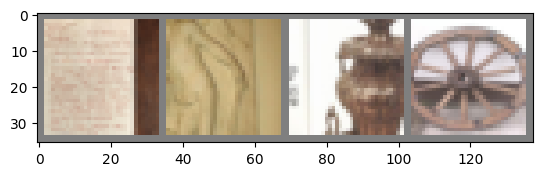

GroundTruth:  Графика Редкие книги Скульптура Фото, негативы
Predict class - Минералогия, real class - Фото, негативы, probability (Археология,Графика) - tensor([-1.3002, -0.9001,  0.3366, -1.2484, -0.6311,  0.6008,  1.3854, -0.1201,
        -0.8161,  0.1161,  0.7398, -0.0869,  0.4821,  1.2718,  1.3152])
Predict class - Редкие книги, real class - Документы, probability (Археология,Графика) - tensor([-1.0007, -0.0555,  0.5748,  0.2051, -0.6265,  0.4821, -1.0601,  0.9151,
        -1.7763,  1.1691,  0.2975,  1.9407, -0.4501, -0.2972, -0.5085])
Predict class - Редкие книги, real class - Редкие книги, probability (Археология,Графика) - tensor([-1.7487,  1.4453,  0.5615,  2.3786, -0.1599, -0.1256, -1.6572, -1.8219,
        -2.0903,  0.6425, -0.0291,  3.6692,  0.1790, -0.3285, -0.9392])
Predict class - Живопись, real class - Минералогия, probability (Археология,Графика) - tensor([-0.9564,  0.0618,  0.7539, -2.3918,  0.0805,  1.6866,  0.0593,  0.5960,
        -1.1373, -0.5150, -0.1739,  0.4059

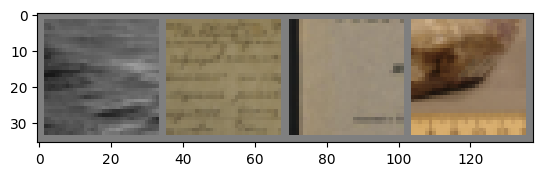

GroundTruth:  Минералогия Редкие книги Редкие книги Живопись
Predict class - Редкие книги, real class - Редкие книги, probability (Археология,Графика) - tensor([-1.3560,  1.6018,  0.1124,  2.1167, -0.4349, -0.4773, -2.2732, -1.0102,
        -1.5640,  1.7619, -0.0110,  2.7411, -1.0481, -0.3430,  0.2600])
Predict class - Техника, real class - Скульптура, probability (Археология,Графика) - tensor([-1.8520, -0.7866,  0.9787, -1.0833, -0.9811,  1.0160,  0.3691, -0.0315,
        -0.7499,  0.0861,  0.6675,  0.2520,  0.3243,  1.5011,  1.0827])
Predict class - Минералогия, real class - Техника, probability (Археология,Графика) - tensor([ 2.3422, -1.7499,  1.5733, -3.3012,  3.2436, -2.6685,  3.9221,  2.2755,
         0.0620, -2.6557,  1.5177, -1.8692,  1.2820,  0.9294, -2.7829])
Predict class - ДПИ, real class - Скульптура, probability (Археология,Графика) - tensor([-0.9592, -0.7853,  1.3707, -1.4568,  0.4145,  1.1274, -0.4961, -0.2864,
        -0.4937, -0.0224,  0.1569,  0.3930,  0.2931,  0.974

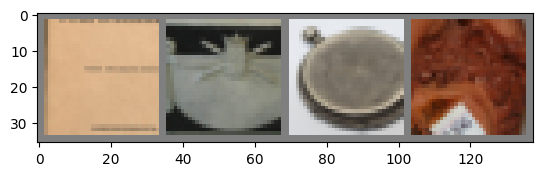

GroundTruth:  Редкие книги Техника Минералогия   ДПИ
Predict class - Живопись, real class - Редкие книги, probability (Археология,Графика) - tensor([-1.5871,  0.1120,  0.6686, -1.8104, -0.1592,  1.9159, -0.7135,  0.2276,
        -1.4908,  0.2113,  0.3344,  0.5854,  0.8077,  0.5934, -0.1349])
Predict class - Живопись, real class - Техника, probability (Археология,Графика) - tensor([-1.8428,  0.2224,  0.7660, -1.8928,  0.5845,  2.3127, -0.3512, -0.7085,
        -1.5952, -0.1013,  0.3175,  0.7106,  0.4120,  0.3918, -0.2342])
Predict class - Нумизматика, real class - Нумизматика, probability (Археология,Графика) - tensor([ 2.0432,  0.2499,  0.9345, -1.7189,  2.3332, -3.1533, -1.6133,  3.5194,
        -0.3120, -2.0324,  0.8677, -1.0106,  2.0479,  0.6361, -2.9728])
Predict class - Фото, негативы, real class - Фото, негативы, probability (Археология,Графика) - tensor([-2.6729, -0.2442,  0.0999, -1.3513, -0.4115,  1.0761, -0.0384, -0.4311,
        -0.9010, -0.5095,  0.4940, -0.2934,  1.0644,  

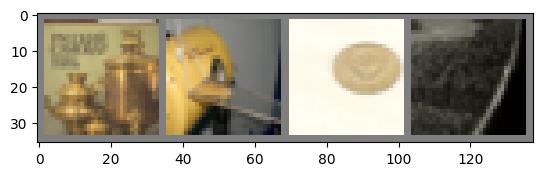

GroundTruth:  Живопись Живопись Нумизматика Фото, негативы
Predict class - Живопись, real class - Печатная продукция, probability (Археология,Графика) - tensor([-1.9082,  0.3785,  0.3818, -2.3818, -0.1365,  2.5468, -0.6736,  0.2792,
        -1.3313, -0.4911,  0.0528,  0.0718,  1.1947,  0.5886,  0.1125])
Predict class - Нумизматика, real class - Нумизматика, probability (Археология,Графика) - tensor([ 1.4981,  1.0165,  0.6444, -1.4982,  1.6167, -4.1905, -1.3577,  3.9508,
         0.8956, -2.5864,  0.7190, -2.8135,  2.2481,  0.7718, -2.2340])
Predict class - Скульптура, real class - Скульптура, probability (Археология,Графика) - tensor([ 0.7340, -1.0210,  1.9773, -2.5700,  1.0273, -1.8201,  1.4531,  0.6721,
         0.8042, -1.7730,  0.9690, -1.0207,  2.1156,  1.3058, -2.0633])
Predict class - Редкие книги, real class - Документы, probability (Археология,Графика) - tensor([-1.3842,  2.1609,  0.0535,  2.5592,  0.0702, -1.6413, -1.4087, -1.5296,
        -1.2861, -0.0415,  0.2341,  2.7979, 

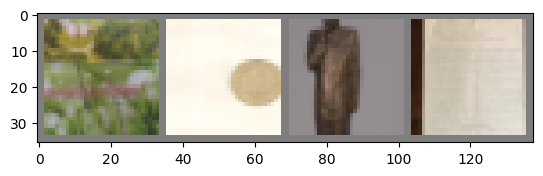

GroundTruth:  Живопись Нумизматика Скульптура Редкие книги
Predict class - Техника, real class - ДПИ, probability (Археология,Графика) - tensor([-1.3065, -0.3345,  1.1090, -1.4030, -0.5192, -0.2875,  0.0384,  0.0470,
        -0.3484, -0.0831,  0.3814, -0.0869,  1.1855,  1.3250,  0.2288])
Predict class - Редкие книги, real class - Документы, probability (Археология,Графика) - tensor([-1.3896,  2.2722, -0.3408,  2.6126,  0.2510, -1.1880, -2.2188, -1.1571,
        -2.6089,  1.5989,  0.3011,  3.3204, -0.6280, -0.9820,  0.0715])
Predict class - Фото, негативы, real class - Фото, негативы, probability (Археология,Графика) - tensor([-1.8215, -1.3442,  0.0256, -1.4527,  0.4452,  0.4454,  0.3408, -1.0342,
        -1.6704, -0.5209,  1.4353,  0.5828,  1.2282,  0.8799,  1.9292])
Predict class - Нумизматика, real class - Техника, probability (Археология,Графика) - tensor([ 1.6879, -1.3622,  1.7068, -1.3810,  1.1418, -2.5550,  0.4386,  3.5179,
        -0.6464, -1.3660,  1.5397,  0.0339,  0.1854,  0.

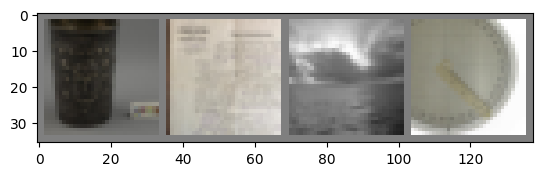

GroundTruth:  Техника Редкие книги Фото, негативы Нумизматика
Predict class - Фото, негативы, real class - Скульптура, probability (Археология,Графика) - tensor([-1.7409, -0.9249,  0.6641, -1.4415, -0.2739, -0.0546, -0.7827, -0.1829,
        -0.5668, -0.1227,  0.5004,  0.2735,  1.0754,  1.0680,  1.6270])
Predict class - Печатная продукция, real class - Редкие книги, probability (Археология,Графика) - tensor([ 1.4423, -0.2636, -0.3260,  0.3951,  0.7168, -2.1076, -2.4027,  0.1591,
         0.5910,  1.9166,  1.7992,  0.7507,  0.0498,  0.2700, -0.5916])
Predict class - ДПИ, real class - ДПИ, probability (Археология,Графика) - tensor([-0.1671, -0.9489,  1.3109, -0.8296,  0.3898,  0.6773,  0.5539,  0.1654,
        -0.6575, -0.7859,  0.2214,  1.1226,  0.4571,  0.6489, -1.4166])
Predict class - Редкие книги, real class - Минералогия, probability (Археология,Графика) - tensor([-0.3782, -0.0630,  0.6377,  0.0354, -0.0169,  0.2641, -0.6085, -0.1224,
        -1.3202,  0.3010, -0.0968,  2.2994,  0.

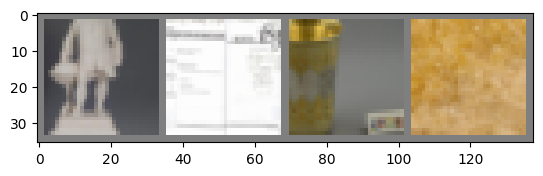

GroundTruth:  Фото, негативы Печатная продукция   ДПИ Редкие книги
Predict class - Графика, real class - Документы, probability (Археология,Графика) - tensor([-1.1479,  1.6262,  0.0240,  1.1482,  1.0279, -0.6892, -1.3270,  0.0385,
        -1.7300,  0.7808, -0.3369,  0.4383, -0.1968, -0.6771,  0.0177])
Predict class - Техника, real class - Прочие, probability (Археология,Графика) - tensor([-1.5236, -0.9445,  0.6096, -1.6629, -1.1275, -0.0259,  1.6532,  0.0219,
        -1.6453, -0.4153,  1.3519,  1.1178,  0.9376,  1.7515,  1.3543])
Predict class - Живопись, real class - Минералогия, probability (Археология,Графика) - tensor([-1.3768,  0.1801,  0.6186, -1.3804,  0.1712,  1.6312, -0.0702, -0.2624,
        -1.6097,  0.0134,  0.2851,  1.2643,  0.4987,  0.3799, -0.4881])
Predict class - Естественнонауч.коллекция, real class - Техника, probability (Археология,Графика) - tensor([-0.7217,  0.3677,  0.0621,  0.9105,  1.2292, -0.9399, -0.3823,  0.0555,
        -1.0361,  0.5457,  0.2174,  0.4024, -

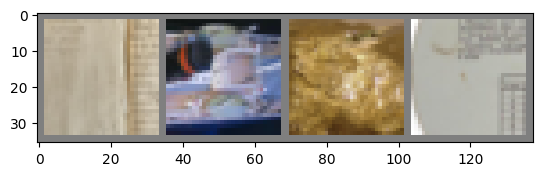

GroundTruth:  Графика Техника Живопись Естественнонауч.коллекция
Predict class - Живопись, real class - Живопись, probability (Археология,Графика) - tensor([-1.4761, -0.7399,  1.3983, -2.0213,  0.4512,  1.5121, -0.5126, -0.6678,
        -0.3460, -0.4670,  0.4943,  0.6789,  0.6796,  0.8190, -0.7247])
Predict class - Фото, негативы, real class - Графика, probability (Археология,Графика) - tensor([-1.0931, -1.3005,  0.2889, -1.8396, -0.5518, -0.2479, -1.0757, -0.2339,
        -0.5251,  0.9973,  1.3554,  1.1009,  0.3819,  1.4567,  2.2929])
Predict class - Техника, real class - Техника, probability (Археология,Графика) - tensor([ 0.9198, -3.0149,  0.6679, -2.8079, -0.1290, -1.1903, -2.4716, -1.3282,
         2.6443, -0.3044,  3.1263,  1.4608,  0.5686,  3.1781,  2.0703])
Predict class - Техника, real class - Археология, probability (Археология,Графика) - tensor([-0.7914, -0.6725,  1.3014, -1.3225,  0.4192, -0.4231, -2.2720, -0.3693,
         1.3523,  0.0193,  1.0543,  0.2027, -0.0977,  1.828

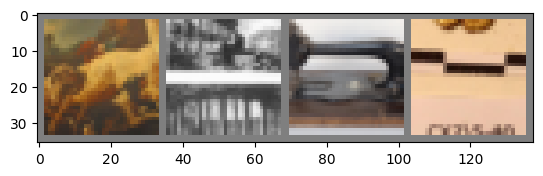

GroundTruth:  Живопись Фото, негативы Техника Техника
Predict class - Фото, негативы, real class - Фото, негативы, probability (Археология,Графика) - tensor([-2.6996, -1.1295,  0.0657, -1.5872, -1.6737,  0.1704, -0.7790, -0.4169,
        -0.8189,  0.5923,  1.0474,  0.8503,  0.9720,  2.0374,  3.0422])
Predict class - Нумизматика, real class - Графика, probability (Археология,Графика) - tensor([ 0.1325,  0.3809,  0.3316, -0.4087, -0.1196,  0.0151, -0.8110,  1.3326,
        -1.3534,  0.6639,  0.1891,  0.6104, -0.0142,  0.1507, -0.8298])
Predict class - Естественнонауч.коллекция, real class - Естественнонауч.коллекция, probability (Археология,Графика) - tensor([ 1.0976, -0.6927,  0.8349, -1.1681,  3.0363, -2.1543, -0.4744,  0.5347,
        -0.4825, -1.1768,  1.1828, -1.3036,  0.8603,  0.8114, -0.5650])
Predict class - Скульптура, real class - Фото, негативы, probability (Археология,Графика) - tensor([-0.0222,  0.2282,  0.3538, -0.5499,  0.7491, -0.5022, -0.1319, -0.3989,
        -0.9527,  

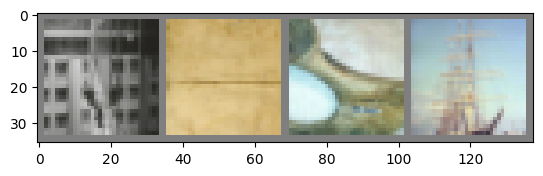

GroundTruth:  Фото, негативы Нумизматика Естественнонауч.коллекция Скульптура
Predict class - Печатная продукция, real class - Археология, probability (Археология,Графика) - tensor([-0.2955,  0.3835,  0.6003,  0.3483,  0.0526, -0.3489, -2.1381,  0.0903,
        -0.1885,  1.1032,  0.3149,  0.5069, -0.6398,  0.7516, -0.2929])
Predict class - Живопись, real class - Живопись, probability (Археология,Графика) - tensor([-1.4427,  0.2314,  0.7889, -2.4240, -0.2015,  2.0999, -0.4898,  0.6551,
        -1.5822,  0.3680,  0.2580,  0.3740,  0.7030,  0.7746, -0.2358])
Predict class - Минералогия, real class - Прочие, probability (Археология,Графика) - tensor([ 1.0879, -2.0169,  1.9351, -2.2444,  1.3902, -0.9449,  2.1560,  0.1956,
         1.1705, -1.8487,  1.0240, -0.5250,  0.0544,  1.4888, -1.4653])
Predict class - Фото, негативы, real class - Фото, негативы, probability (Археология,Графика) - tensor([-2.5588e+00, -7.1881e-01,  5.7510e-04, -2.1612e+00, -4.5987e-01,
         1.1485e+00,  1.5412e+00

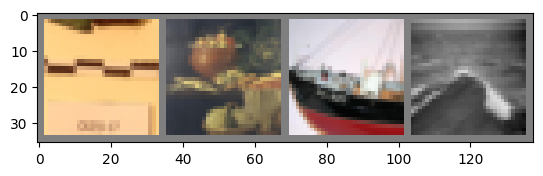

GroundTruth:  Печатная продукция Живопись Минералогия Фото, негативы
Predict class - Фото, негативы, real class - Прочие, probability (Археология,Графика) - tensor([-1.6762, -1.4723,  0.4694, -2.8374,  0.0222,  0.3231, -0.0434, -0.8914,
        -1.1435,  0.3110,  1.6130,  0.6756,  0.7877,  1.7043,  2.2774])
Predict class - Живопись, real class - Живопись, probability (Археология,Графика) - tensor([-1.7132e+00, -6.8870e-01,  1.6922e+00, -3.5275e+00,  8.4504e-01,
         1.8723e+00, -1.2228e+00, -4.4425e-01, -3.3535e-03, -1.1882e+00,
         8.0994e-01, -6.3343e-01,  1.5202e+00,  1.3491e+00, -8.0615e-01])
Predict class - Археология, real class - Естественнонауч.коллекция, probability (Археология,Графика) - tensor([ 0.8870, -0.4602,  0.1438, -0.3013,  0.2204, -1.2184, -1.1309,  0.3592,
        -0.3119,  0.1829,  0.4692,  0.8631,  0.8244, -0.1006, -0.3899])
Predict class - Редкие книги, real class - Прочие, probability (Археология,Графика) - tensor([-1.2277, -0.5000,  1.0801, -1.0986, -0

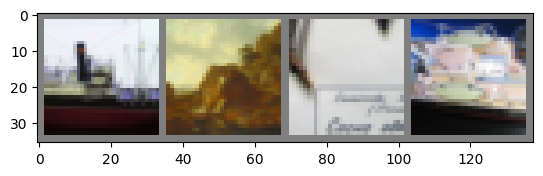

GroundTruth:  Фото, негативы Живопись Археология Редкие книги
Predict class - Техника, real class - Оружие, probability (Археология,Графика) - tensor([-2.4343, -0.3014,  1.6426, -2.4927, -1.2745, -0.6641,  0.9573,  1.0848,
        -1.2010,  0.5466,  1.0522, -0.4722,  1.3336,  2.3932,  0.9320])
Predict class - Редкие книги, real class - Редкие книги, probability (Археология,Графика) - tensor([ 0.0404,  0.1984, -0.6421,  2.1572, -0.3503, -1.9445, -2.7577, -0.5427,
        -0.3162,  2.6354,  1.5737,  2.7393, -0.8447, -0.2759, -0.1622])
Predict class - ДПИ, real class - Графика, probability (Археология,Графика) - tensor([ 0.0581, -0.6238,  1.0895, -1.3462,  0.8546,  0.0572, -0.1577,  0.1331,
        -0.1006, -0.6843,  0.1454, -0.1879,  0.2503,  1.0285, -0.4155])
Predict class - Живопись, real class - Документы, probability (Археология,Графика) - tensor([-1.6407,  0.0754,  0.3418, -1.1073, -1.1218,  2.0365, -0.6752,  0.9433,
        -0.9608,  0.1426,  0.1569,  0.4393,  0.2490,  0.3721,  0.1

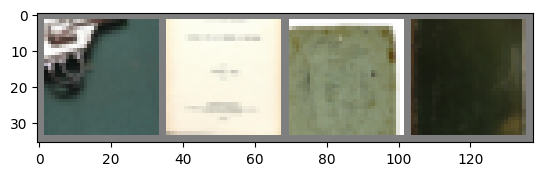

GroundTruth:  Техника Редкие книги   ДПИ Живопись
Predict class - Техника, real class - Скульптура, probability (Археология,Графика) - tensor([-0.9234, -0.3572, -0.0608, -1.3350, -0.2590, -1.0407, -1.9426, -1.0770,
         0.1961, -0.2676,  1.1384,  0.4093,  1.2808,  1.6301,  1.4398])
Predict class - Живопись, real class - Минералогия, probability (Археология,Графика) - tensor([-0.4859, -0.1685,  0.6225, -1.2966,  0.0220,  1.0173,  0.3376,  0.8752,
        -1.4816, -0.0016,  0.2046,  0.8154,  0.4176,  0.1472, -0.6325])
Predict class - Оружие, real class - Прочие, probability (Археология,Графика) - tensor([ 1.5996, -3.3485,  3.1576, -3.4056,  2.0320, -2.2862, -2.7450, -2.5243,
         5.5751, -2.4691,  3.1953,  0.1339,  1.0051,  4.2750, -1.0761])
Predict class - Естественнонауч.коллекция, real class - Естественнонауч.коллекция, probability (Археология,Графика) - tensor([ 1.5166, -1.0503,  1.4208, -2.3605,  3.9258, -1.5798, -1.5875, -2.4984,
         1.6702,  0.4877,  3.6613, -1.4592, 

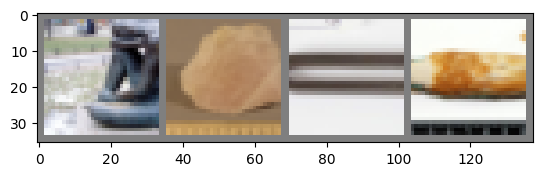

GroundTruth:  Техника Живопись Оружие Естественнонауч.коллекция
Predict class - Скульптура, real class - Печатная продукция, probability (Археология,Графика) - tensor([ 0.2227,  0.8726,  0.5745, -0.2648,  0.0519,  0.0579, -1.7507, -0.5471,
        -0.1818, -0.7593,  0.2336,  0.9343,  1.2875,  0.2342, -1.7731])
Predict class - Редкие книги, real class - Редкие книги, probability (Археология,Графика) - tensor([-1.9531, -0.5439,  0.8582,  1.6569, -1.5541,  0.1009, -1.3013,  0.2866,
        -1.8943,  2.5186,  1.3767,  2.7226, -0.8827, -0.2822, -0.2636])
Predict class - Оружие, real class - Оружие, probability (Археология,Графика) - tensor([ 3.7828e+00, -5.1293e+00,  3.7348e+00, -4.3717e+00,  2.8168e+00,
        -6.5540e+00, -6.6649e+00, -3.2443e+00,  1.0578e+01, -2.1203e+00,
         4.7483e+00, -1.1595e+00,  3.8368e-01,  6.0421e+00, -3.3287e-03])
Predict class - ДПИ, real class - Графика, probability (Археология,Графика) - tensor([ 0.5369, -0.6637,  1.3173, -0.7552,  0.6527, -0.6950, -0.3

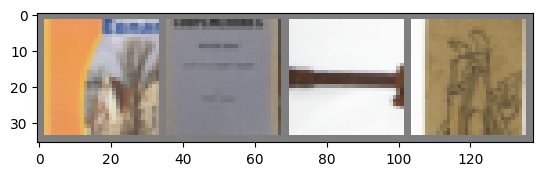

GroundTruth:  Скульптура Редкие книги Оружие   ДПИ
Predict class - Минералогия, real class - Техника, probability (Археология,Графика) - tensor([ 1.5672, -2.7827,  2.6056, -3.0379,  3.0174, -2.5384,  3.3754,  1.2726,
         1.3587, -3.6259,  0.8707,  0.4214,  1.6856,  2.6740, -4.8987])
Predict class - Редкие книги, real class - Техника, probability (Археология,Графика) - tensor([ 0.2161, -0.7748,  1.2565, -0.8916,  0.2644, -0.5019,  0.4195,  0.8214,
        -0.9686, -0.0150,  0.4123,  1.8517,  0.5129,  0.2001, -1.7679])
Predict class - Оружие, real class - Документы, probability (Археология,Графика) - tensor([-0.5706, -1.4070,  0.8716,  0.9151, -0.1330, -1.4930, -1.8401, -1.6694,
         4.4018,  0.2150,  1.4170,  1.8394, -0.6076,  1.8462, -1.0569])
Predict class - Прочие, real class - Техника, probability (Археология,Графика) - tensor([ 1.2877,  0.0110, -0.1297, -0.0475,  0.5770, -2.4702, -2.1893,  0.8658,
         0.3299,  1.0873,  1.3729,  0.2262,  0.5609,  0.3571, -0.5045])


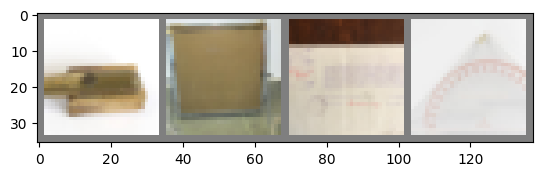

GroundTruth:  Минералогия Редкие книги Оружие Прочие
Predict class - Техника, real class - Оружие, probability (Археология,Графика) - tensor([-0.7036, -0.7387,  0.4427, -1.3541, -0.4563, -0.7858,  0.9439,  0.8623,
        -1.1989,  0.4234,  0.4440,  0.4954,  0.4488,  1.1817,  0.5945])
Predict class - Археология, real class - Техника, probability (Археология,Графика) - tensor([ 1.6873, -0.3937, -0.0149, -1.0100,  0.9704, -2.4732, -2.6750,  0.9454,
         0.7620, -0.3701,  1.2676, -0.3524,  1.5237,  0.7329, -0.4217])
Predict class - Редкие книги, real class - Минералогия, probability (Археология,Графика) - tensor([-0.2668, -0.9945,  1.1867, -1.4326,  0.9583,  0.3858,  0.6818, -0.1611,
        -0.6849, -0.4782,  0.2662,  1.2098,  0.5114,  0.5955, -1.4782])
Predict class - Естественнонауч.коллекция, real class - Нумизматика, probability (Археология,Графика) - tensor([ 2.0563, -1.7373,  3.1111, -3.5624,  4.2991, -4.1965,  0.1622,  4.1161,
        -0.4543, -4.0231,  1.5705,  2.1462,  2.366

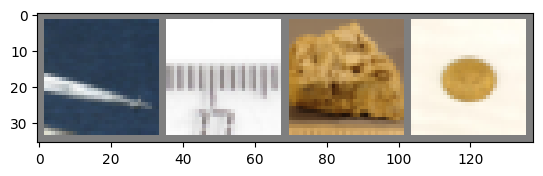

GroundTruth:  Техника Археология Редкие книги Естественнонауч.коллекция
Predict class - Фото, негативы, real class - Графика, probability (Археология,Графика) - tensor([-1.2288,  0.2652, -0.7581, -2.0447,  0.0046, -0.2453, -0.5083, -0.5883,
        -2.0737,  1.1922,  0.9733,  0.8877,  0.5286,  0.3674,  3.6422])
Predict class - Редкие книги, real class - ДПИ, probability (Археология,Графика) - tensor([-0.9963, -0.0992,  0.8590, -1.0336, -0.8126,  1.2979, -1.0865,  0.6527,
        -0.8079,  0.3634,  0.2553,  1.5387,  0.2983,  0.1135, -0.9262])
Predict class - Редкие книги, real class - Графика, probability (Археология,Графика) - tensor([-0.4048, -0.5976,  0.8199, -0.3696,  0.0260,  0.6780, -0.4870,  0.1943,
        -1.3407,  0.0208, -0.0354,  2.3433,  0.3036,  0.0172, -1.2069])
Predict class - Живопись, real class - Живопись, probability (Археология,Графика) - tensor([-3.8186,  0.1357,  0.7008, -2.1227, -1.0839,  1.7190, -0.7215, -0.4435,
        -1.3229,  0.1290, -0.0330,  0.2803,  1.47

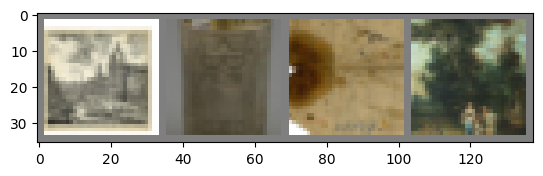

GroundTruth:  Фото, негативы Редкие книги Редкие книги Живопись
Predict class - Живопись, real class - Графика, probability (Археология,Графика) - tensor([-1.1961,  0.0093,  0.4866, -1.2875, -0.0910,  1.1997,  0.2990,  0.2481,
        -1.1954,  0.1680, -0.0143,  0.4086,  0.4995,  0.1088,  0.1081])
Predict class - Техника, real class - Оружие, probability (Археология,Графика) - tensor([-0.7858, -1.0318,  0.4203, -1.3167, -0.1713, -0.4448, -0.0184, -0.1854,
        -0.2657, -0.0269,  0.9689,  0.2005,  0.3441,  1.4409,  1.2485])
Predict class - Живопись, real class - Живопись, probability (Археология,Графика) - tensor([-1.6959,  0.0350,  0.6391, -1.7747, -1.0327,  2.6763, -1.0677,  0.6565,
        -1.0784, -0.1589,  0.2502,  1.3620,  0.3757,  0.5228, -0.5034])
Predict class - Редкие книги, real class - Минералогия, probability (Археология,Графика) - tensor([-1.4992, -0.8724,  0.4918,  0.5357, -0.5520,  0.5047,  0.2847, -0.5420,
        -2.1466,  1.3007,  1.0357,  2.9000, -0.0391, -0.0596,

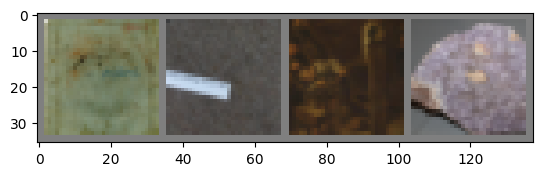

GroundTruth:  Живопись Техника Живопись Редкие книги
Predict class - Оружие, real class - Техника, probability (Археология,Графика) - tensor([ 4.3371, -3.5162,  2.0034, -3.9200,  2.6192, -4.5775, -4.9480, -0.7652,
         6.5494, -1.9900,  3.3899, -1.5680,  1.7899,  4.1501, -0.6804])
Predict class - Минералогия, real class - Нумизматика, probability (Археология,Графика) - tensor([ 1.8181, -1.9875,  1.9168, -2.7308,  1.6699, -1.8313,  2.6712,  0.8407,
         1.0048, -2.8080,  1.2593, -1.2055,  1.2140,  1.9292, -2.0131])
Predict class - Документы, real class - Редкие книги, probability (Археология,Графика) - tensor([-1.5837,  1.7438,  0.2120,  2.7826, -0.1700, -0.7372, -2.4595, -0.7864,
        -1.7164,  2.5005,  0.4301,  1.6798, -1.3702, -0.6994,  0.3831])
Predict class - Редкие книги, real class - Нумизматика, probability (Археология,Графика) - tensor([-0.2961,  0.0082,  0.7246, -0.9714, -0.0580,  0.5907,  0.7158,  0.9270,
        -1.8833,  0.0327,  0.2825,  1.1790,  0.2441,  0.1146

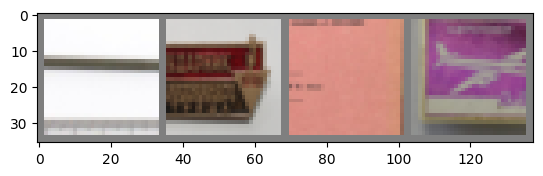

GroundTruth:  Оружие Минералогия Документы Редкие книги
Predict class - Фото, негативы, real class - Фото, негативы, probability (Археология,Графика) - tensor([-2.2101, -1.7553, -0.3730, -2.2445, -0.2517,  0.6832,  0.8502, -1.6943,
        -1.4059,  0.3153,  2.5626,  0.5374,  0.8392,  1.6958,  4.6372])
Predict class - ДПИ, real class - ДПИ, probability (Археология,Графика) - tensor([-0.3935, -0.3257,  1.3913, -1.4483, -0.2992, -0.3816,  0.6791,  1.0310,
        -0.3487, -0.2913,  0.4587,  0.0152,  0.7781,  0.9496, -0.9520])
Predict class - Скульптура, real class - Скульптура, probability (Археология,Графика) - tensor([-1.6649, -0.0810,  1.3668, -2.6395, -0.6149, -3.5467, -1.3958, -2.2274,
         1.8804, -1.6519,  2.6319, -1.7655,  4.0914,  3.3866,  1.7906])
Predict class - Редкие книги, real class - Минералогия, probability (Археология,Графика) - tensor([-1.5376,  0.2968,  0.8318, -1.0571,  0.1845,  1.2080, -0.0463, -0.4171,
        -1.7099,  0.0610,  0.1309,  1.3475,  0.6232,  0.463

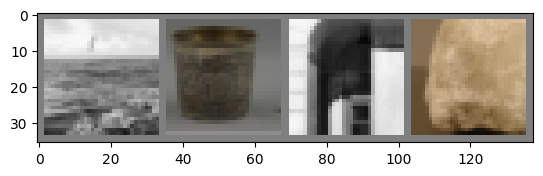

GroundTruth:  Фото, негативы   ДПИ Скульптура Редкие книги
Predict class - Скульптура, real class - Техника, probability (Археология,Графика) - tensor([ 0.2835, -0.7144,  0.9750, -1.9041,  0.5257, -0.1223, -0.1303,  0.1681,
         0.1065, -0.6796,  0.7061, -1.5571,  1.8400,  1.0804, -0.5278])
Predict class - Прочие, real class - Прочие, probability (Археология,Графика) - tensor([-0.3742, -2.5628,  1.4298, -4.1106, -0.4536, -0.3794, -0.2240, -0.5418,
         0.2926,  0.4393,  3.6951,  0.7481,  0.2420,  3.4094,  1.7311])
Predict class - Редкие книги, real class - Печатная продукция, probability (Археология,Графика) - tensor([-2.0981, -0.0256,  0.5806,  2.4694, -0.9386,  0.1526, -0.9639, -0.7903,
        -2.3907,  2.1982,  1.4765,  2.5780, -0.7718, -0.3098,  0.4185])
Predict class - Естественнонауч.коллекция, real class - Нумизматика, probability (Археология,Графика) - tensor([ 2.0178, -0.2463,  1.0772, -1.1614,  3.2782, -4.2145, -1.1192,  2.7655,
        -0.4059, -2.0148,  1.4915, -1.

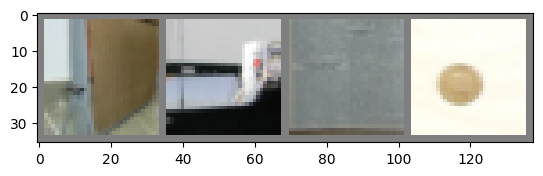

GroundTruth:  Скульптура Прочие Редкие книги Естественнонауч.коллекция
Predict class - Техника, real class - Прочие, probability (Археология,Графика) - tensor([-0.4148, -1.5597,  0.7447, -1.7865,  0.6431, -1.4582, -1.9927, -0.8063,
         0.5914,  0.2269,  1.5769,  0.6200,  0.2699,  1.7541,  1.5860])
Predict class - Естественнонауч.коллекция, real class - Нумизматика, probability (Археология,Графика) - tensor([ 0.9953,  0.1144,  0.0106, -0.3186,  1.6661, -2.4570, -1.2093,  0.9295,
         1.0813,  0.6574,  1.2599, -0.7260,  0.5465,  0.9072, -1.2498])
Predict class - Археология, real class - Нумизматика, probability (Археология,Графика) - tensor([ 1.5614, -0.5708, -0.0089, -0.3588,  0.1891, -2.4928, -2.0122,  0.6256,
         1.0470,  1.2906,  1.4142, -0.0455,  0.6171,  0.4725, -0.4555])
Predict class - Фото, негативы, real class - Фото, негативы, probability (Археология,Графика) - tensor([-3.0401, -0.8320,  0.3167, -2.3605, -0.6452,  0.5092,  0.3165, -0.4654,
        -0.9521, -0.512

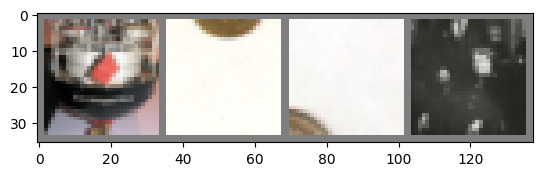

GroundTruth:  Техника Естественнонауч.коллекция Археология Фото, негативы
Predict class - Техника, real class - Оружие, probability (Археология,Графика) - tensor([-1.0873, -0.8828,  1.1695, -1.7372, -0.0294, -0.3120,  0.0397, -0.5544,
         0.8642, -1.0735,  0.9458,  0.2193,  0.2239,  2.3575,  0.9274])
Predict class - Естественнонауч.коллекция, real class - Естественнонауч.коллекция, probability (Археология,Графика) - tensor([-0.1773, -1.1048,  1.3845, -0.2773,  1.4350, -0.3009, -1.4179, -0.7810,
         0.7728, -0.4748,  0.5668,  0.5262,  0.7159,  1.2370, -1.5099])
Predict class - Фото, негативы, real class - Фото, негативы, probability (Археология,Графика) - tensor([-0.9513, -1.4119, -0.0259, -1.7652,  0.4034, -0.0263, -0.1916, -0.6672,
        -1.1045,  0.1140,  1.5051,  0.2639,  0.6162,  0.8118,  2.7530])
Predict class - Оружие, real class - Документы, probability (Археология,Графика) - tensor([-0.2325, -1.8068,  1.0680,  0.2923,  0.5543, -1.7275, -1.4748, -1.7249,
         5.1

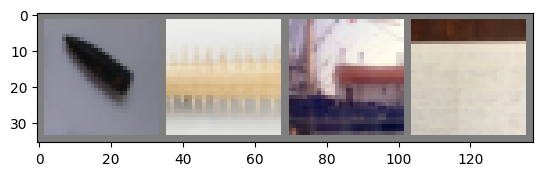

GroundTruth:  Техника Естественнонауч.коллекция Фото, негативы Оружие
Predict class - Нумизматика, real class - Археология, probability (Археология,Графика) - tensor([ 1.2422e+00,  3.3103e-01,  4.4675e-01, -4.5132e-01,  1.4543e-01,
        -6.9458e-01, -2.6453e+00,  1.6039e+00, -3.9434e-01,  1.3342e+00,
         1.0512e+00,  2.0920e-03, -1.6511e-01,  9.7726e-01, -1.7279e+00])
Predict class - ДПИ, real class - ДПИ, probability (Археология,Графика) - tensor([-0.8520, -0.3110,  1.4618, -0.1188,  0.4189,  0.3973,  0.2065, -0.2396,
        -1.1946,  0.0598,  0.1926,  0.3551,  0.3410,  0.5216, -0.6440])
Predict class - Редкие книги, real class - Оружие, probability (Археология,Графика) - tensor([-0.0182, -0.1000,  0.8775, -1.1175,  0.0983,  0.3230, -0.2056,  0.4995,
        -1.2774, -0.1589, -0.1002,  1.9820,  0.7854,  0.1098, -1.3219])
Predict class - Редкие книги, real class - Документы, probability (Археология,Графика) - tensor([-1.1704,  2.0245,  0.3373,  1.4416, -0.3262, -0.4499, -1.765

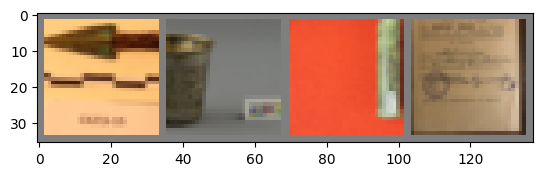

GroundTruth:  Нумизматика   ДПИ Редкие книги Редкие книги
Predict class - Фото, негативы, real class - Фото, негативы, probability (Археология,Графика) - tensor([-0.1346, -2.4225,  0.0559, -1.3015, -0.0679, -0.6928, -1.0041, -1.2791,
         1.4965,  0.2740,  1.9693,  0.1548, -0.3280,  1.3527,  3.8447])
Predict class - Редкие книги, real class - Редкие книги, probability (Археология,Графика) - tensor([-1.5960,  0.3911,  0.7175,  3.2044, -1.9263, -0.6869, -3.1672, -0.7329,
        -1.0724,  2.0006,  0.7945,  5.0339, -1.2908, -0.0919, -1.1864])
Predict class - Редкие книги, real class - Оружие, probability (Археология,Графика) - tensor([ 0.1804, -0.1490,  0.9630, -1.1353,  0.8324, -0.4034,  0.7406,  0.7720,
        -1.3007, -0.5465,  0.0949,  1.2186,  0.5753,  0.1660, -1.2977])
Predict class - Скульптура, real class - Фото, негативы, probability (Археология,Графика) - tensor([ 0.4555, -0.7863,  0.5341, -2.5901,  1.7692, -2.3507,  0.2194,  0.0435,
        -0.7575, -1.4826,  1.2449, -1.55

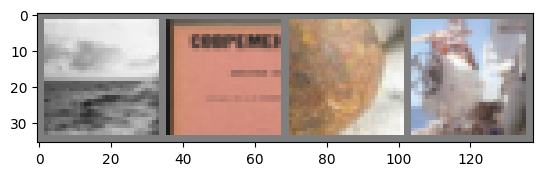

GroundTruth:  Фото, негативы Редкие книги Редкие книги Скульптура
Predict class - Редкие книги, real class - Печатная продукция, probability (Археология,Графика) - tensor([-1.3546,  1.9160, -0.0321,  1.9602, -0.2978, -0.6065, -2.1791, -0.7935,
        -1.9520,  1.9104, -0.1663,  2.7055, -0.9027, -0.6077,  0.2149])
Predict class - Фото, негативы, real class - Фото, негативы, probability (Археология,Графика) - tensor([-1.5445, -1.3758,  0.3631, -3.1344,  1.4505, -0.4101, -0.5883, -1.2480,
        -0.4204, -0.9161,  1.2874, -0.7851,  1.2696,  1.3769,  2.7094])
Predict class - Нумизматика, real class - Редкие книги, probability (Археология,Графика) - tensor([ 2.3915, -1.8675,  2.6183, -3.1463,  2.0503, -2.6886,  1.4837,  4.6509,
        -0.4167, -2.6279,  1.7728,  0.1236,  1.1429,  1.7050, -4.8495])
Predict class - Печатная продукция, real class - Археология, probability (Археология,Графика) - tensor([-0.3319, -0.0611,  0.4915, -0.2807,  0.2467,  0.4476, -0.6276,  0.2333,
        -0.8995, 

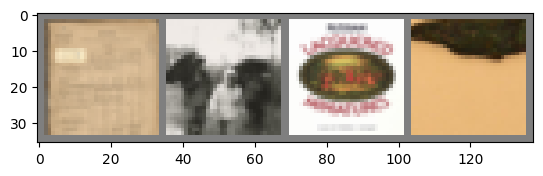

GroundTruth:  Редкие книги Фото, негативы Нумизматика Печатная продукция
Predict class - Скульптура, real class - Скульптура, probability (Археология,Графика) - tensor([-1.4139, -0.3337,  2.0923, -4.2164,  0.3370, -4.6743, -2.1398, -2.2169,
         2.0652, -2.0809,  2.4886, -2.3396,  5.4774,  3.4309,  1.0469])
Predict class - Редкие книги, real class - Графика, probability (Археология,Графика) - tensor([-0.2096,  1.3811,  0.1391,  0.6666,  0.8540, -1.5752, -1.6008,  1.5232,
        -2.9167,  1.0464,  0.4752,  2.1454, -0.5853, -0.9879, -0.4107])
Predict class - Редкие книги, real class - Документы, probability (Археология,Графика) - tensor([-0.7997,  1.4178, -0.1778,  1.8457, -0.8459, -1.0674, -2.5754,  0.9339,
        -2.3592,  2.2822,  0.9332,  3.0418, -1.1128, -0.8973, -0.3155])
Predict class - Редкие книги, real class - Нумизматика, probability (Археология,Графика) - tensor([-1.3143,  0.6122,  0.1751,  1.8784, -1.0651, -1.0696, -2.5567,  0.7510,
        -2.0372,  2.1452,  0.7676,  

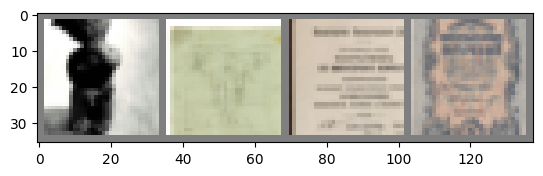

GroundTruth:  Скульптура Редкие книги Редкие книги Редкие книги
Predict class - Живопись, real class - Живопись, probability (Археология,Графика) - tensor([-2.7252,  0.6699,  0.3581, -2.4679, -0.5562,  2.3317, -1.0973,  0.0803,
        -1.5846, -0.0343,  0.0641,  0.4477,  1.4304,  0.6870,  0.5470])
Predict class - Скульптура, real class - ДПИ, probability (Археология,Графика) - tensor([-1.5012,  0.4300,  0.5291, -1.5881, -0.0601,  1.0402, -0.3024, -0.1876,
        -0.8496, -0.1832,  0.2251, -0.2168,  1.3875,  0.4799,  0.1344])
Predict class - Документы, real class - Редкие книги, probability (Археология,Графика) - tensor([-1.7630,  1.7280,  0.2113,  3.0412,  0.2317, -0.6457, -2.2231, -0.8510,
        -1.9377,  2.2267,  0.4812,  1.1912, -1.1934, -0.7348,  0.1762])
Predict class - Печатная продукция, real class - Редкие книги, probability (Археология,Графика) - tensor([-1.5447,  0.9979,  0.3977,  2.1600,  0.3190, -0.4380, -1.3826, -0.3889,
        -1.7874,  2.2536,  0.6228,  1.5050, -1.0

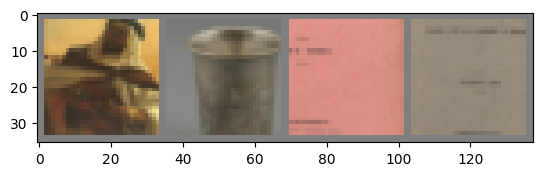

GroundTruth:  Живопись Скульптура Документы Печатная продукция
Predict class - Естественнонауч.коллекция, real class - Печатная продукция, probability (Археология,Графика) - tensor([ 1.1038, -1.9975,  1.0397, -2.2550,  1.5572, -1.5596,  0.7111, -0.7022,
         1.2731, -1.0033,  0.8748, -0.9939,  0.1097,  1.3845,  0.6719])
Predict class - Нумизматика, real class - Нумизматика, probability (Археология,Графика) - tensor([ 2.2555, -0.8095,  0.9590,  0.2064,  2.8592, -3.7606, -2.4554,  2.9727,
        -0.7175, -1.4438,  1.0521,  0.2043,  1.8234,  1.0886, -2.9456])
Predict class - Скульптура, real class - Скульптура, probability (Археология,Графика) - tensor([-0.5695, -0.0789,  1.2026, -3.0575,  0.5206,  0.7572, -0.3882,  1.2185,
        -0.9735, -0.7759,  0.7536, -0.7135,  1.8732,  0.8567, -0.9637])
Predict class - Скульптура, real class - Естественнонауч.коллекция, probability (Археология,Графика) - tensor([ 1.4803, -1.6860,  2.4249, -4.3808,  2.9733, -3.9998,  0.3241,  1.9129,
         

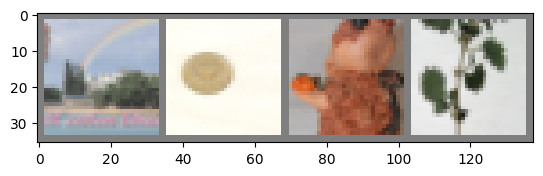

GroundTruth:  Естественнонауч.коллекция Нумизматика Скульптура Скульптура
Predict class - Редкие книги, real class - Скульптура, probability (Археология,Графика) - tensor([-1.0205, -0.0839,  0.5131, -0.8646, -0.7341,  1.3483, -0.9234,  0.9229,
        -1.2623,  0.4351,  0.2234,  1.4749,  0.0831, -0.0647, -0.5773])
Predict class - Археология, real class - Графика, probability (Археология,Графика) - tensor([ 3.0459, -2.0332,  0.0113, -4.3253,  2.5308, -2.4906, -1.1161,  0.6946,
         1.0262, -1.3903,  2.3089, -1.8232,  1.4432,  1.6439,  1.0002])
Predict class - Редкие книги, real class - Скульптура, probability (Археология,Графика) - tensor([-1.4692,  0.4185,  0.4705,  0.7354,  0.3741,  0.7341,  0.2596, -1.2924,
        -1.8713,  0.7259,  0.2039,  1.5318, -0.0416, -0.0842,  0.2296])
Predict class - Редкие книги, real class - Естественнонауч.коллекция, probability (Археология,Графика) - tensor([-0.6641, -0.3601,  0.5335,  0.0581, -0.4710,  0.4170, -1.0139,  0.9813,
        -1.5864,  0.

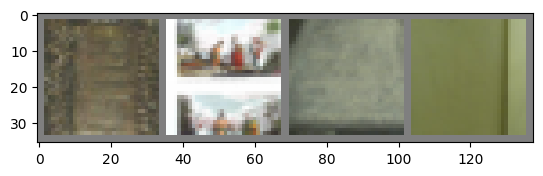

GroundTruth:  Редкие книги Археология Редкие книги Редкие книги
Predict class - Минералогия, real class - Минералогия, probability (Археология,Графика) - tensor([ 0.2686, -0.7723,  0.9023, -1.2771,  0.8293, -0.2108,  1.6776, -0.0424,
        -0.2923, -0.3164,  0.4685, -0.0902,  0.1116,  0.6203, -0.8740])
Predict class - Редкие книги, real class - Естественнонауч.коллекция, probability (Археология,Графика) - tensor([-0.7607,  0.2867,  0.6440, -0.9760,  0.0551,  0.5263, -0.0391,  0.3642,
        -1.3697,  0.3692, -0.2692,  0.8939,  0.2176,  0.0716, -0.2292])
Predict class - Естественнонауч.коллекция, real class - Графика, probability (Археология,Графика) - tensor([-0.5749,  0.8227,  0.2388, -0.2395,  1.3740, -0.7005, -0.1060, -0.0142,
        -1.6717,  0.2919,  0.2377,  0.1058,  0.6172, -0.1907, -0.0712])
Predict class - Живопись, real class - Скульптура, probability (Археология,Графика) - tensor([-0.7844, -0.1920,  0.7397, -1.1703, -0.6757,  1.5299, -1.1440,  1.0994,
        -1.0618, -0

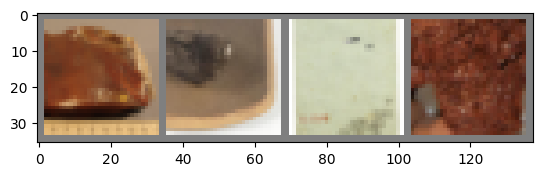

GroundTruth:  Минералогия Редкие книги Естественнонауч.коллекция Живопись
Predict class - Скульптура, real class - Редкие книги, probability (Археология,Графика) - tensor([-1.9092, -0.2029,  0.7555, -0.6898,  0.0222,  0.6746,  0.8249, -1.1565,
        -1.6410, -0.2357,  0.5998,  0.8284,  1.0675,  0.7207,  0.7572])
Predict class - Фото, негативы, real class - Печатная продукция, probability (Археология,Графика) - tensor([-2.7659, -0.1631,  0.1042, -1.3480, -1.4115,  0.8694,  0.2582, -0.5711,
        -1.2925,  0.5798,  0.2043,  0.5729,  1.3857,  1.1639,  1.8974])
Predict class - Живопись, real class - Живопись, probability (Археология,Графика) - tensor([-1.3956,  0.0596,  0.6182, -2.0292,  0.0318,  2.0807, -0.3777, -0.0157,
        -1.5490, -0.0779,  0.3158,  1.2392,  0.7705,  0.4688, -0.5553])
Predict class - Живопись, real class - Скульптура, probability (Археология,Графика) - tensor([-1.1896,  0.1883,  0.8388, -2.2760, -0.3302,  1.6991, -0.7377,  0.7818,
        -0.8001, -0.3884,  0.1

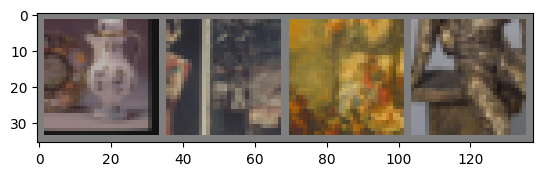

GroundTruth:  Скульптура Фото, негативы Живопись Живопись
Predict class - Живопись, real class - Живопись, probability (Археология,Графика) - tensor([-1.2154, -0.4456,  0.8769, -1.9930, -0.1428,  2.3989, -0.2985, -0.4729,
        -0.4582, -0.5000,  0.1474,  1.2761,  0.1951,  0.5693, -0.7455])
Predict class - ДПИ, real class - ДПИ, probability (Археология,Графика) - tensor([-0.5309, -0.2812,  1.4608, -1.4937,  0.2013,  0.0833,  0.6627,  0.4254,
        -0.5182, -0.1510,  0.1983, -0.2320,  0.3609,  0.8216, -0.4564])
Predict class - Естественнонауч.коллекция, real class - Археология, probability (Археология,Графика) - tensor([ 0.9415, -0.0438,  0.6143, -1.1755,  1.6935, -1.7237, -1.7171,  1.0218,
         0.1622, -0.0771,  1.1791, -1.7471,  1.0022,  1.0964, -0.7072])
Predict class - Фото, негативы, real class - Фото, негативы, probability (Археология,Графика) - tensor([-1.6976, -1.8336, -0.0484, -1.5646, -0.3441,  0.2805, -0.1109, -1.3501,
        -0.6900, -0.0077,  2.3507,  1.3492,  0.67

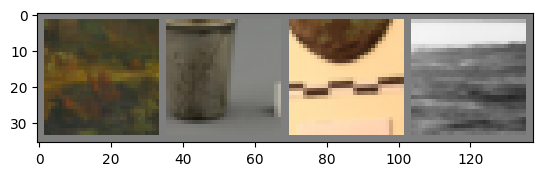

GroundTruth:  Живопись   ДПИ Естественнонауч.коллекция Фото, негативы
Predict class - Документы, real class - Печатная продукция, probability (Археология,Графика) - tensor([-0.9209,  1.1129,  0.3290,  1.3355,  0.4947, -0.2249, -1.7689, -0.3696,
        -1.2882,  1.2328, -0.0994,  0.7054, -0.6152, -0.1940, -0.0367])
Predict class - Археология, real class - Техника, probability (Археология,Графика) - tensor([ 1.7095, -0.6724,  0.2825, -1.5071,  0.9103, -0.8460, -0.3400,  0.3450,
         0.2851, -0.1172,  0.8796, -0.5857,  0.3274,  0.8724, -0.5222])
Predict class - Живопись, real class - Минералогия, probability (Археология,Графика) - tensor([-0.1576, -0.2545,  0.1398, -1.1137,  0.5217,  0.5953,  0.4972,  0.1231,
        -0.8823,  0.4527,  0.1917,  0.1891,  0.0995,  0.2328, -0.3677])
Predict class - Живопись, real class - Оружие, probability (Археология,Графика) - tensor([-1.8752,  0.3526,  0.8884, -2.0544, -0.3011,  1.6073, -0.9543,  0.5660,
        -1.7642,  0.7071,  0.2300,  0.6712,  

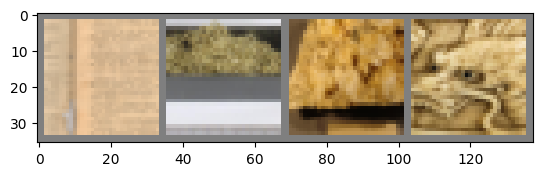

GroundTruth:  Документы Археология Живопись Живопись
Predict class - Нумизматика, real class - Археология, probability (Археология,Графика) - tensor([ 0.4522,  0.5564,  0.3956, -0.3023,  0.5608, -0.3946, -2.0511,  1.5996,
        -1.1137,  0.9098,  0.9558, -0.2155,  0.3836,  0.8159, -1.3321])
Predict class - Редкие книги, real class - Живопись, probability (Археология,Графика) - tensor([-1.0044,  0.6127,  0.4041,  0.0783,  0.2681,  0.3816, -0.4390, -0.2490,
        -1.8762,  0.6780, -0.3227,  1.8323,  0.0410, -0.2569, -0.2103])
Predict class - Фото, негативы, real class - Фото, негативы, probability (Археология,Графика) - tensor([-2.2498, -0.1624,  0.1067, -1.1756, -0.5553,  1.0444,  0.2914, -0.3091,
        -1.2691,  0.2418,  0.0091,  0.2739,  0.8148,  0.8970,  1.5565])
Predict class - Археология, real class - Археология, probability (Археология,Графика) - tensor([ 1.4693,  0.2138,  0.8417, -1.0219,  0.3083, -0.4796, -2.9433,  1.3757,
        -0.0464,  1.4224,  1.1742, -0.0546, -0.268

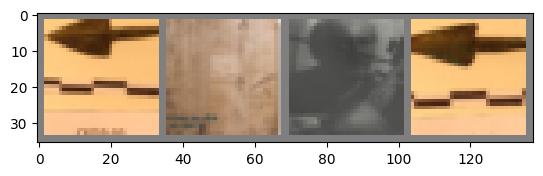

GroundTruth:  Нумизматика Редкие книги Фото, негативы Археология
Predict class - ДПИ, real class - Прочие, probability (Археология,Графика) - tensor([-1.1084, -1.0935,  1.5903, -1.9056,  0.0194,  0.5200,  0.1224, -0.1715,
        -0.8124,  0.4312,  1.2741,  0.8961,  0.2406,  1.3212, -0.3141])
Predict class - ДПИ, real class - ДПИ, probability (Археология,Графика) - tensor([-1.4537, -0.1348,  2.1407, -2.2162,  0.0691, -0.1632, -0.1243, -0.1414,
        -0.3362, -0.2180,  0.3173, -0.4000,  1.1423,  1.4243, -0.1854])
Predict class - Скульптура, real class - Естественнонауч.коллекция, probability (Археология,Графика) - tensor([ 0.2341, -1.0542,  0.7094, -4.1708,  1.5451, -0.5640,  0.3175,  0.7993,
        -0.7247, -1.8856,  0.5039, -1.5061,  2.4788,  1.1123,  0.6001])
Predict class - Минералогия, real class - Прочие, probability (Археология,Графика) - tensor([-2.6085, -1.5092,  0.9413, -2.6557, -1.8530,  1.3320,  2.8530,  0.0722,
        -2.7257,  0.1115,  1.4857,  2.2252,  1.2226,  2.0072

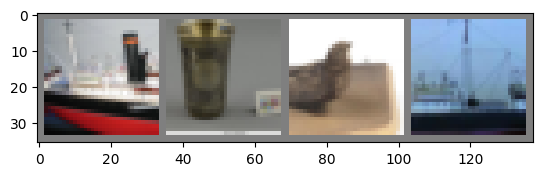

GroundTruth:    ДПИ   ДПИ Скульптура Минералогия
Predict class - Скульптура, real class - Печатная продукция, probability (Археология,Графика) - tensor([-2.0791,  0.5473,  1.8482, -3.8916,  1.1045, -0.1744, -0.8068, -0.0267,
        -0.2998, -0.8551, -0.1977, -1.8408,  1.9190,  1.2552,  0.5411])
Predict class - Живопись, real class - ДПИ, probability (Археология,Графика) - tensor([-1.1515e+00,  9.8861e-02,  6.8073e-01, -1.4253e+00,  1.0843e-02,
         1.2919e+00,  1.1975e-02,  3.5692e-01, -1.1232e+00,  1.2858e-01,
         1.5678e-01, -1.4092e-03,  2.8711e-01,  3.6175e-01,  5.0098e-02])
Predict class - Естественнонауч.коллекция, real class - Прочие, probability (Археология,Графика) - tensor([-2.5957, -0.7751,  0.6746, -3.8043,  2.6028,  0.8549,  1.3753, -2.8905,
        -1.4137, -0.9207,  1.8538, -0.6066,  1.2084,  1.5827,  2.2669])
Predict class - Скульптура, real class - Скульптура, probability (Археология,Графика) - tensor([-0.0522, -1.5730,  2.9889, -5.0079,  1.2701, -6.0501,  1.

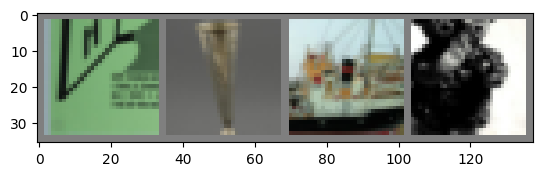

GroundTruth:  Скульптура Живопись Естественнонауч.коллекция Скульптура
Predict class - Техника, real class - Археология, probability (Археология,Графика) - tensor([-0.7118, -0.0334,  0.5976, -1.0586, -0.3636,  0.8383, -0.6127,  0.5734,
        -0.9189,  0.0912,  0.2314, -0.0056,  0.4030,  0.8917,  0.0824])
Predict class - Печатная продукция, real class - Редкие книги, probability (Археология,Графика) - tensor([-0.2058,  0.3618, -0.1986,  0.9838,  0.1812, -1.4778, -1.3765, -0.4135,
        -0.0884,  1.5517,  0.6269,  0.9885, -0.1879, -0.0391, -0.0292])
Predict class - Редкие книги, real class - Редкие книги, probability (Археология,Графика) - tensor([-1.3362,  1.3146,  0.3212,  2.4975, -1.1165, -0.9478, -2.6973,  0.4547,
        -1.9384,  2.7238,  0.4582,  3.1911, -1.7478, -0.7030,  0.0057])
Predict class - Скульптура, real class - ДПИ, probability (Археология,Графика) - tensor([-0.2258, -0.6353,  1.7122, -2.2648,  0.1007,  0.1978, -0.3310, -0.2168,
         0.5000, -0.7703,  0.5941, -0

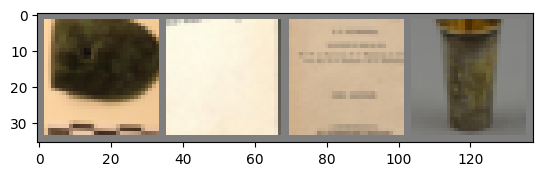

GroundTruth:  Техника Печатная продукция Редкие книги Скульптура
Predict class - Фото, негативы, real class - Фото, негативы, probability (Археология,Графика) - tensor([-4.5494, -2.3237, -0.5134, -4.7759, -0.6788,  0.5303, -0.0132, -1.5492,
        -1.8077, -0.4023,  3.0092,  0.2107,  2.3203,  3.9482,  5.1542])
Predict class - Редкие книги, real class - Документы, probability (Археология,Графика) - tensor([-0.8222, -0.2140,  0.4955, -0.5378, -0.3740,  0.8715, -0.5357,  0.7543,
        -1.4854,  0.4996,  0.2188,  1.8369, -0.0694, -0.2272, -0.6426])
Predict class - Нумизматика, real class - Техника, probability (Археология,Графика) - tensor([ 1.8474, -1.3286,  1.5548, -1.5784,  0.8900, -1.7687,  1.0346,  2.6779,
         0.0794, -1.3465,  1.5034, -1.2791,  0.4536,  1.1080, -1.9267])
Predict class - Живопись, real class - Археология, probability (Археология,Графика) - tensor([-0.5476, -0.1611,  0.6467, -2.2808,  0.5344,  1.2346,  0.6651,  0.5128,
        -0.9599, -0.6292,  0.2308, -0.1195

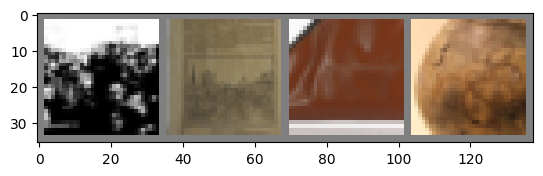

GroundTruth:  Фото, негативы Редкие книги Нумизматика Живопись
Predict class - Редкие книги, real class - Прочие, probability (Археология,Графика) - tensor([-1.1007, -0.2115,  0.8201, -1.1871, -0.5187,  0.6855,  0.7611, -0.0184,
        -1.7048,  0.2241,  0.5081,  1.6915,  0.3591,  0.6363,  0.0833])
Predict class - Живопись, real class - Минералогия, probability (Археология,Графика) - tensor([-1.5817,  0.1201,  0.6103, -1.0005, -0.0395,  1.5083,  0.5847, -0.6199,
        -1.4888,  0.3447,  0.0522,  0.6213,  0.3837,  0.1994,  0.3172])
Predict class - Техника, real class - Прочие, probability (Археология,Графика) - tensor([-1.9558, -1.1947,  1.1585, -3.0527,  0.6918,  1.0451, -0.7673, -0.8736,
        -0.9790,  0.0909,  1.5941,  0.4024,  1.2159,  1.6929,  0.8015])
Predict class - Редкие книги, real class - Документы, probability (Археология,Графика) - tensor([-1.0009, -0.0786,  0.4679,  0.0271, -0.5661,  0.6076, -0.6482,  0.8211,
        -1.6872,  1.0577,  0.2562,  1.7026, -0.2950, -0.31

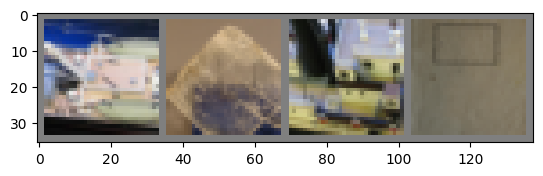

GroundTruth:  Редкие книги Живопись Техника Редкие книги
Predict class - Живопись, real class - Графика, probability (Археология,Графика) - tensor([-1.0148,  0.0453,  0.3960, -1.9681,  0.4244,  1.3175,  0.9514,  0.0317,
        -1.0457, -0.5893,  0.0190, -0.0582,  0.8505,  0.2268,  0.0742])
Predict class - Живопись, real class - Естественнонауч.коллекция, probability (Археология,Графика) - tensor([-1.7559, -0.0599,  0.5433, -2.1509, -0.3487,  1.9982, -1.0150,  0.6967,
        -1.7705,  0.6445,  0.6010,  0.0664,  0.9157,  1.1120,  0.2317])
Predict class - Фото, негативы, real class - Прочие, probability (Археология,Графика) - tensor([-0.9661, -2.1154,  0.4107, -1.8319, -0.9114, -0.5090, -0.3163, -1.4377,
         1.1465,  0.1171,  2.3081,  0.5846,  0.1252,  2.4600,  3.5554])
Predict class - Редкие книги, real class - Оружие, probability (Археология,Графика) - tensor([-1.7128, -0.9905,  0.9787, -1.5291, -1.3636,  0.1929,  0.4053,  1.3569,
        -1.8887,  1.2624,  0.7609,  1.7986,  0.15

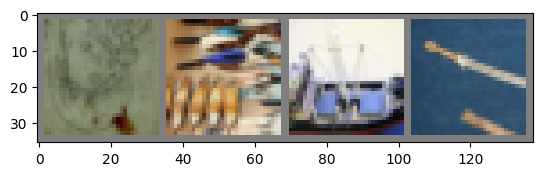

GroundTruth:  Живопись Живопись Фото, негативы Редкие книги
Predict class - Печатная продукция, real class - Археология, probability (Археология,Графика) - tensor([-0.4804,  0.2864,  0.7191,  0.2664, -0.4405, -0.1853, -2.0095, -0.3101,
         0.0706,  0.9931,  0.4489,  0.8662, -0.6082,  0.8421, -0.0830])
Predict class - Фото, негативы, real class - Фото, негативы, probability (Археология,Графика) - tensor([-1.6399, -1.4674, -0.1832, -1.0499, -0.2266,  0.5240,  0.2373, -0.8986,
        -1.3116,  0.5006,  1.4727,  0.9384,  0.4585,  0.9733,  2.8501])
Predict class - Графика, real class - Печатная продукция, probability (Археология,Графика) - tensor([-0.5294,  1.3607, -0.0981,  0.8648,  0.7930, -1.4271, -1.3842,  0.4996,
        -2.2331,  1.2916,  0.3310,  1.3400, -0.1439, -0.7844,  0.0867])
Predict class - Редкие книги, real class - Графика, probability (Археология,Графика) - tensor([-1.1109,  0.5510, -0.5016,  1.8106, -0.6592, -1.6789, -3.6381, -0.1553,
        -0.8567,  2.1000,  1.349

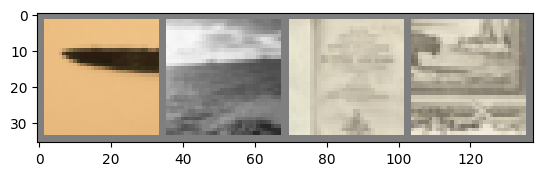

GroundTruth:  Печатная продукция Фото, негативы Графика Редкие книги
Predict class - Графика, real class - Документы, probability (Археология,Графика) - tensor([-1.0909,  2.9354,  0.0668,  1.5539,  0.5189, -1.6561, -2.2626, -0.5845,
        -1.6411, -0.5806, -0.2464,  1.1714,  0.4334, -0.6992,  0.1993])
Predict class - Естественнонауч.коллекция, real class - Нумизматика, probability (Археология,Графика) - tensor([ 1.8818, -0.5627,  1.9550, -2.7194,  2.2954, -1.3396,  1.7774,  2.1597,
        -2.0940, -1.4228,  1.3039,  1.6383,  1.4441,  0.6502, -3.7366])
Predict class - Естественнонауч.коллекция, real class - Оружие, probability (Археология,Графика) - tensor([ 0.0323, -0.8928,  1.2792, -1.2311,  1.6517, -0.8835,  1.0521,  0.7498,
         0.0019, -1.3072,  0.3240, -0.3666,  0.6919,  0.9554, -1.6454])
Predict class - Естественнонауч.коллекция, real class - Естественнонауч.коллекция, probability (Археология,Графика) - tensor([-0.6542,  0.4851, -0.0588, -0.3744,  1.8521, -0.6824, -0.2739,

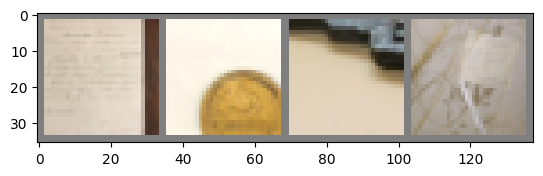

GroundTruth:  Графика Естественнонауч.коллекция Естественнонауч.коллекция Естественнонауч.коллекция
Predict class - ДПИ, real class - Техника, probability (Археология,Графика) - tensor([-0.0270, -0.8379,  1.1499, -0.2845, -0.1264, -0.1171,  0.2402,  0.3193,
        -0.1878,  0.0532,  0.2925,  0.7549, -0.4117,  0.5472, -0.6783])
Predict class - Печатная продукция, real class - Археология, probability (Археология,Графика) - tensor([-0.2525, -0.1936,  0.4866, -0.5837, -0.3425, -0.1597, -1.7111,  0.4392,
        -0.3237,  1.2561,  0.6966,  0.5450, -0.1182,  0.9355, -0.1853])
Predict class - Графика, real class - Скульптура, probability (Археология,Графика) - tensor([-1.1941,  0.7802,  0.5240,  0.1563,  0.7770, -0.7119, -1.0595,  0.4520,
        -2.0491,  0.3572,  0.3004,  0.1427,  0.6481, -0.1537,  0.4764])
Predict class - Техника, real class - Нумизматика, probability (Археология,Графика) - tensor([ 0.6336, -1.1196,  1.2274, -2.3816,  1.5393, -1.5221, -0.4440,  1.0523,
        -0.0101, -0

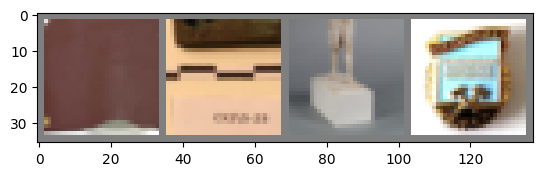

GroundTruth:    ДПИ Печатная продукция Графика Техника
Predict class - Редкие книги, real class - Редкие книги, probability (Археология,Графика) - tensor([-1.7440, -0.3679,  1.0984,  2.3846, -1.3005, -0.4804, -1.4340,  0.3348,
        -2.1792,  2.3371,  1.4085,  3.4499, -0.9509, -0.5549, -1.2744])
Predict class - Живопись, real class - Прочие, probability (Археология,Графика) - tensor([-1.6105, -1.0087,  1.1015, -2.8854,  1.0633,  2.1823,  0.5073, -1.3973,
        -0.8714, -0.3131,  1.2565,  0.5861,  0.5743,  1.0264, -0.2041])
Predict class - ДПИ, real class - ДПИ, probability (Археология,Графика) - tensor([-0.6156, -0.0450,  1.3063, -2.3090,  0.5366,  0.2771,  0.6401,  0.5638,
        -0.3871, -0.8449,  0.0796, -0.5916,  1.1342,  0.7707, -0.7209])
Predict class - Оружие, real class - Прочие, probability (Археология,Графика) - tensor([ 0.7599, -3.5020,  2.4651, -2.6286,  1.3721, -1.1717, -0.9704, -3.2685,
         4.0465, -0.6671,  3.2937,  0.4770, -1.7806,  3.0340,  1.1669])


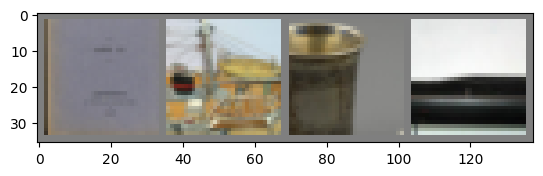

GroundTruth:  Редкие книги Живопись   ДПИ Оружие
Predict class - Редкие книги, real class - Археология, probability (Археология,Графика) - tensor([-0.0302, -0.1724,  0.5520, -0.5849,  0.4464,  0.3310, -0.1021,  0.3505,
        -1.2830,  0.0882, -0.1197,  1.0718,  0.3653,  0.0412, -0.5447])
Predict class - Редкие книги, real class - Нумизматика, probability (Археология,Графика) - tensor([-1.0942,  0.0435,  0.8439, -0.6886,  0.4105,  0.7625, -0.7383, -0.1670,
        -1.9312,  0.5553,  0.6949,  1.3683,  0.5017,  0.6212, -0.6498])
Predict class - ДПИ, real class - Минералогия, probability (Археология,Графика) - tensor([-0.9172, -0.3840,  1.0577, -0.3758,  0.3514,  0.7209, -0.1560, -0.2843,
        -1.3077,  0.5360,  0.6796,  0.9870, -0.0233,  0.6083, -0.7575])
Predict class - Прочие, real class - Археология, probability (Археология,Графика) - tensor([ 0.9052, -0.1179,  0.3690, -1.0003,  0.1646, -0.1712, -0.4743,  0.3230,
        -0.4682,  0.9003,  1.0021,  0.1066, -0.1463,  0.9588, -0.985

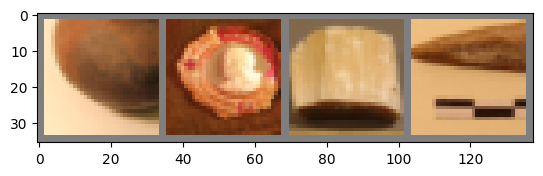

GroundTruth:  Редкие книги Редкие книги   ДПИ Прочие
Predict class - Редкие книги, real class - Документы, probability (Археология,Графика) - tensor([-1.1663,  0.3036,  0.4543, -0.5762, -0.2593,  0.6584, -0.6112,  0.4190,
        -1.6170,  0.8487,  0.1251,  1.0828,  0.3131, -0.0145, -0.0964])
Predict class - Минералогия, real class - Минералогия, probability (Археология,Графика) - tensor([-0.4452, -0.5314,  0.5443, -1.8585,  0.7709,  0.2148,  1.9947, -0.5168,
        -0.5605, -0.3809,  0.2228, -0.4358,  0.7137,  0.7290,  0.1187])
Predict class - ДПИ, real class - ДПИ, probability (Археология,Графика) - tensor([-1.0109, -0.4134,  0.9568, -2.0464,  0.4153,  0.6537,  0.7262, -0.1712,
        -0.5896, -0.3764,  0.0789, -0.2391,  0.4365,  0.7139,  0.1099])
Predict class - Живопись, real class - Живопись, probability (Археология,Графика) - tensor([-2.5091,  0.2056,  0.6554, -3.0316, -0.3860,  2.9807, -1.0392,  0.2146,
        -1.4499, -0.3558,  0.5004,  0.0864,  1.4969,  1.0319,  0.1859])


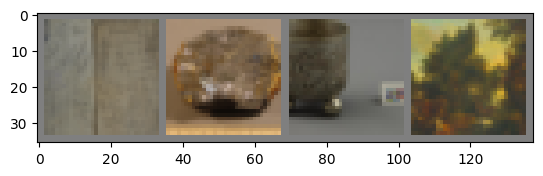

GroundTruth:  Редкие книги Минералогия   ДПИ Живопись
Accuracy of the network on the 360 test images: 27 %


In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for printdata in list(zip(predicted,labels,outputs)):
            printclass =[classes[int(printdata[0])],classes[int(printdata[1])]]
            print('Predict class - {0}, real class - {1}, probability ({2},{3}) - {4}'.format( printclass[0],printclass[1], classes[0], classes [1],printdata[2]))

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        imshow(torchvision.utils.make_grid(images))
        print('GroundTruth: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
print('Accuracy of the network on the', dataset_sizes['test'], 'test images: %d %%' % (
    100 * correct / total))